# High-mountain Asia Glacier Mass Balance

Companion notebook for analysis and figure generation for:

## A systematic, regional assessment of High-Mountain Asia glacier mass balance
### Shean et al. (2019), Frontiers in Earth Science

In [ ]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
#%matplotlib notebook
%matplotlib inline

In [4]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import scipy.stats

from osgeo import gdal

from imview.lib import pltlib
from pygeotools.lib import iolib, geolib, malib
from adjustText import adjust_text

import geopandas as gpd
import cartopy.crs as ccrs 

In [5]:
#Default pandas options
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)

In [6]:
#Default matplotlib options
plt_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0.01}

In [7]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

In [8]:
#Root sum of squared errors
def rss(a, c=0.0):
    #return ((a**2).sum() + c*a.prod())**0.5
    return ((a**2).sum())**0.5

#Root mean squared errors
def rms(a):
    return ((a**2).mean())**0.5

In [9]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.sum, rss], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.sum, rss, rms], \
               'mb_Gta':[np.sum], \
               'mb_Gta_sigma':[np.mean, np.sum, rss, rms], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max], \
               'z_med':[np.mean, np.median, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64')
    
    #Sigma for ('mb_mwea','mean'), assumign errors are dependent is ('mb_mwea_sigma', 'mean') - sum of errors divided by n samples
    #Sigma for ('mb_mwea','mean'), assuming errors for each glacier are independent, with equal weight
    glac_df_mb_agg[('mb_mwea_sigma', 'rss_mean')] = glac_df_mb_agg[('mb_mwea_sigma', 'rss')]/glac_df_mb_agg[('mb_mwea', 'count')]
    
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    
    #Gta and Gta_sigma estimate converted to m_wea
    glac_df_mb_agg[('mb_mwea', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta','sum')]/glac_df_mb_agg[('Area', 'sum')]
    glac_df_mb_agg[('mb_mwea_sigma', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta_sigma','sum')]/glac_df_mb_agg[('Area', 'sum')]
    
    #Cumulative numbers for full time period
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater (polygons with mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_m3wea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_m3a_sigma')] = glac_df_mb_agg_meltwater[('mb_m3wea_sigma', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_Gta_sigma')] = glac_df_mb_agg[('meltwater', 'total_m3a_sigma')]/1E9
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    glac_df_mb_agg[('meltwater', 'total_mmSLEa_sigma')] = glac_df_mb_agg[('meltwater', 'total_Gta_sigma')]/Gt2mm
    
    #Cumulative meltwater numbers for full time period
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    return glac_df_mb_agg

In [10]:
def spatial_aggregate(glac_df, glac_df_mb, agg_df, col, sort=True):
    glac_df_mb_agg = aggregate(glac_df, glac_df_mb, col)
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    if sort:
        glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [11]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [12]:
def load_hs(hs_fn):
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_clim = malib.calcperc(hs)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    return hs, hs_ds, hs_clim, hs_extent_cartopy

def add_hs(hs, ax, hs_clim, hs_extent_cartopy):
    ax.autoscale(enable=False)
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, alpha=0.6, vmin=hs_clim[0], vmax=hs_clim[1])

In [170]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), sigma_col=None, \
             border_df=None, crs=None, extent=None, hs_bg=True, clim=None, \
             labels='val', title=None, cbar_fmt='%0.1f'):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    label = None
    if 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_mwea_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'mb_Gta_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (Gt/yr)'
    elif 'meltwater_Gta' in col: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        #clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if hs_bg:
        print("Plotting image")
        #hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        #ax.imshow(hs, **hs_style)
        add_hs(hs, ax, hs_clim, hs_extent_cartopy)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        #if hs is not None:
        if hs_bg:
            border_style = {'facecolor':'none','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if False:
        if agg_df is not None:
            print("Plotting agg boundaries")
            #This provides colored regions
            #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
            agg_df.plot(ax=ax, **agg_style)

    #if glac_df_mb is not None:
    if False:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        if 'Area_all' in mb_dissolve_df:
            area_col = 'Area_all'
        elif ('Area_all', 'sum') in mb_dissolve_df:    
            area_col = ('Area_all', 'sum')
        elif ('Area_all', 'sum', 'sum') in mb_dissolve_df:
            area_col = ('Area_all', 'sum', 'sum')

        s = scaling_f * mb_dissolve_df[area_col]
        
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':8, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            txt_list = []
            for k, v in mb_dissolve_df.iterrows():
                if 'sigma' in labels and sigma_col is not None:
                    if labels == 'val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%+0.2f\u00b1%0.2f' % (v[col], v[sigma_col])
                    elif labels == 'name+val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%s\n%+0.2f\u00b1%0.2f' % (k, v[col], v[sigma_col])
                else:
                    if 'name' in labels:
                        lbl = '%s\n%+0.2f' % (k, v[col])
                    else:
                        lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'].values, v['centroid_y'].values), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='w'),path_effects.Normal()])
                txt_list.append(txt)
            
    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])
    
    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col].values, label=label, clim=clim, format=cbar_fmt)
    pltlib.add_scalebar(ax, res=1, location='lower left')
    #pltlib.hide_ticks(ax)

    plt.tight_layout()
    pltlib.latlon_ticks(ax, in_crs=glac_crs)
    #adjust_text(txt_list, arrowprops=dict(arrowstyle='-', ls=':', lw=0.5, color='k'), on_basemap=True)

    return fig

## Define variables

In [41]:
regenerate_files = False

site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = True

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
#suptitle = "Glacier Mass Balance (ASTER 2000–2018)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
#basin_col = 'HYBAS_ID'
basin_col = 'basin_name'
qdgc_col = 'qdgc'
mascon_col = 'mascon'
hex_col = 'id'

extent = None
crs = None

#topdir = '/Users/dshean/data/'
topdir = '/scr/hma/hma_gmb_data'
#topdir = '/nobackup/deshean/data/hma_gmb_data'

In [15]:
if site == 'hma':
    #WBM basin names
    basin_col = 'basin_name'
    #hs_fn = os.path.join(topdir, 'hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif')
    hs_fn = '/scr/hma/TDM1_DEM_90m_hma_DEM_aea_4x_hs_az315.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_HMA_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp')
    #basin_shp_fn = os.path.join(topdir, 'basins/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp')
    basin_shp_fn = os.path.join(topdir, 'basins/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg')
    kaab_region_shp_fn = os.path.join(topdir, 'regions/regions_from_kaab2015_merged_clean_20181111.gpkg')
    region_shp_fn = os.path.join(topdir, 'regions/boundary_mountain_regions_hma_v3_clean.gpkg')
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = os.path.join(topdir, 'qdgc/qdgc_01_asia.shp')
    mascon_shp_fn = os.path.join(topdir, 'mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg')
    hex_shp_fn = os.path.join(topdir, 'hex/hma_25km_hexagons.gpkg')
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_CONUS_aea.shp')
    region_shp_fn = os.path.join(topdir, 'CONUS/regions/conus_mb_regions_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp')
    basin_shp_fn = os.path.join(topdir, 'HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp')
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [16]:
def proc_rgi(glac_shp_fn, pointgeom=True):
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    if pointgeom:
        glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
        glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
        glac_df.set_geometry('centroid_geom', inplace=True, drop=True)
    return glac_df

## Mass balance records
Input csv contains records for each RGI polygon, output of `mb_parallel.py` script

In [17]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]

#mb_csv_fn = os.path.join(topdir, "mb/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181211/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181222/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190207/hma_mb_20190207_0856.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190212/hma_mb_20190213_0143.csv")
#This is std
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213/hma_mb_20190213_1924.csv")
#This is nmad
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad/hma_mb_20190214_1015.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad_hex/hma_mb_20190214_1015_nmad.csv")
mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015.csv")
#This is std + mean
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean.csv")
#Copy for hex analysis
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean.csv")
out_fn_suffix = '_hex_mb_combined'

In [18]:
#Test for no trend filtering
#mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
#out_fn_suffix = '_hex_mb_nofltr'
#Test for ASTER-only
#mb_csv_fn = os.path.join(topdir, "mb/mb_ASTERonly_20190910_fltr/hma_mb_20190910_1840.csv")
#out_fn_suffix = '_hex_mb_ASTER-only'

In [19]:
#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn) and not regenerate_files:
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons from RGI")
    glac_df = proc_rgi(glac_shp_fn)

Loading glacier polygons from RGI


In [20]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    kaab_region_df.rename({'Nyainqentangla':'Nyainqentanglha', 'Pamir Alai':'Pamir Alay'}, inplace=True)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)
    #Dissolve to generate polygons for exorheic and endorheic basins
    if 'ENDO' in basin_df:
        basin_df_endo = basin_df.dissolve('ENDO')

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)
    
if hex_shp_fn is not None:
    print("Loading hex")
    hex_df = gpd.read_file(hex_shp_fn)
    #Convert to glac crs
    hex_df = hex_df.to_crs(glac_df.crs)
    hex_df.set_index(hex_col, inplace=True)

print(glac_df.shape)

Loading borders
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
Loading hex
(95608, 23)


In [21]:
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn) or regenerate_files:
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)
    
    if hex_shp_fn is not None:
        print("One-time spatial join by hex")
        glac_df = gpd.sjoin(glac_df, hex_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':hex_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)
        if 'ENDO' in basin_df:
            print("One-time spatial join by basin exorheic/endorheic")
            glac_df = gpd.sjoin(glac_df, basin_df_endo, how="inner", op="intersects")
            glac_df.rename(index=str, columns={'index_right':'ENDO'}, inplace=True)
            print(glac_df.shape)

One-time spatial join by mascon
(95604, 33)
One-time spatial join by qdgc
(95604, 37)
One-time spatial join by hex
(95591, 42)
One-time spatial join by Kaab region
(94827, 43)
One-time spatial join by region
(94827, 44)
One-time spatial join by basin
(94827, 47)
One-time spatial join by basin exorheic/endorheic
(94827, 49)


In [22]:
if regenerate_files:
    glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df.reset_index().rename(columns={'index':rgi_col}).to_file(glac_shp_join_fn, driver=driver)

Writing out: /scr/hma/hma_gmb_data/mb/mb_combined_20190213_nmad/hma_mb_20190214_1015_rgi60_merge_HMA_aea_join.gpkg


In [23]:
print(glac_df.shape)

(94827, 48)


In [24]:
glac_df.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry', 'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag',
       'lat_center', 'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc',
       'lat', 'lon', 'areakm2', 'id', 'left', 'top', 'right', 'bottom',
       'kaab_region', 'himap_region', 'basin_name', 'DN_left', 'ENDO', 'ENDO',
       'DN_right'],
      dtype='object')

In [25]:
def load_mb(mb_csv_fn):
    print("Loading mb")
    mb_df = pd.read_csv(mb_csv_fn)
    mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
    mb_df.set_index(rgi_col, inplace=True)
    mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
    mb_df['mb_Gta_sigma'] = mb_df['mb_m3wea_sigma']/1E9

    #Update uncertainty for specific mass balance numbers
    #mb_df['mb_mwea_sigma_full'] = mb_df['mb_m3wea_sigma']/mb_df['area_m2']
    return mb_df

## Prepare mb data, join with RGI

In [26]:
mb_df = load_mb(mb_csv_fn)

Loading mb


In [27]:
mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

if os.path.exists(merge_fn) and not regenerate_files:
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    #With index set to RGIId, it is not written out, hack to create new column
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    glac_df_mb.reset_index().rename(columns={'index':rgi_col}).to_file(merge_fn, driver=driver)

print("%i merged records loaded" % (glac_df_mb.shape[0]))

2000.4119999999998 2018.4119999999998
Merging glacier polygons and mb results
(94436, 74)
Writing out: /scr/hma/hma_gmb_data/mb/mb_combined_20190213_nmad/hma_mb_20190214_1015_rgi60_merge_HMA_aea.gpkg
94436 merged records loaded


In [28]:
if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

## Load low-res shaded relief map for figures

In [29]:
hs, hs_ds, hs_clim, hs_extent_cartopy = load_hs(hs_fn)

Loading shaded relief map


## Response to reviewers: compare mb with and without spatial filter on dh/dt maps

In [162]:
mb_fltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015_nmad.csv")
mb_fltr = load_mb(mb_fltr_csv_fn)
mb_nofltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
mb_nofltr = load_mb(mb_nofltr_csv_fn)

Loading mb
Loading mb


In [163]:
mb_fltr.columns

Index(['x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect', 'dhdt_ma',
       'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2', 'mb_m3wea',
       'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc', 'H_m',
       'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma', 'mb_Gta',
       'mb_Gta_sigma'],
      dtype='object')

In [164]:
#mb_diff = mb_fltr[['dhdt_ma','dhdt_ma_sigma']] - mb_nofltr[['dhdt_ma','dhdt_ma_sigma']]
mb_diff = mb_fltr - mb_nofltr

Text(0.5, 0, 'dh/dt uncertainty (m/yr)')

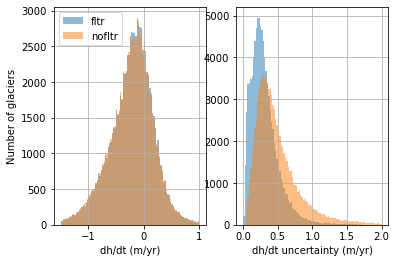

In [165]:
mb_hist_opt = {'bins':100, 'range':(-1.5, 1.0), 'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['dhdt_ma'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
mb_hist_opt['range'] = (0,2)
mb_fltr['dhdt_ma_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("dh/dt (m/yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("dh/dt uncertainty (m/yr)")

Text(0.5, 0, 'Mass balance uncertainty (m w.e./yr)')

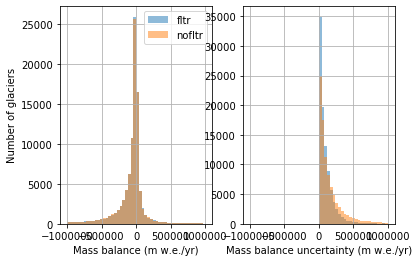

In [167]:
mb_hist_opt = {'bins':50, 'range':(-1E6,1E6),'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['mb_m3wea'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
#mb_hist_opt['range'] = (0,2)
mb_fltr['mb_m3wea_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("Mass balance (m w.e./yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("Mass balance uncertainty (m w.e./yr)")

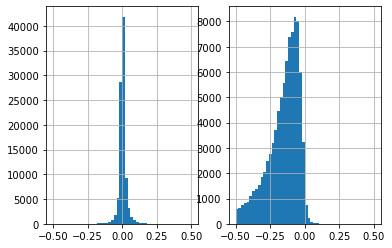

In [168]:
f,axa = plt.subplots(1,2)
mb_diff['dhdt_ma'].hist(ax=axa[0],bins=50, range=(-0.5, 0.5))
mb_diff['dhdt_ma_sigma'].hist(ax=axa[1],bins=50, range=(-0.5, 0.5))

## Evaluate percent of glacier polygon covered by dh/dt map

Text(0.5, 0, 'Percent of polygon with valid data')

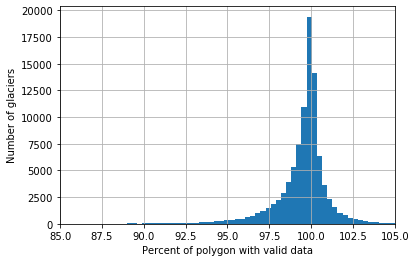

In [30]:
ax = mb_df['valid_area_perc'].hist(bins=128)
ax.set_xlim(85, 105)
ax.set_ylabel("Number of glaciers")
ax.set_xlabel("Percent of polygon with valid data")

In [31]:
#95th percentile of coverage
np.percentile(mb_df['valid_area_perc'], 5)

96.617

In [178]:
mb_df['valid_area_perc'].mean()

99.5031852533496

In [190]:
np.percentile(mb_df['valid_area_perc'], (10))

97.755

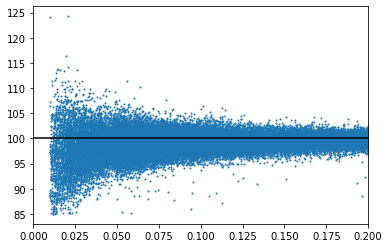

In [32]:
#Glacier area vs. percent coverage
f,ax = plt.subplots()
ax.scatter(mb_df['area_m2']/1E6, mb_df['valid_area_perc'], s=1)
ax.set_xlim(0,0.2)
ax.axhline(100,color='k')

## Final count of DEMs in each stack

In [72]:
#Generate text files from valid DEMs that were included in stacks
#cd /nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack
#parallel --progress 'wc -l {}/*fn_list.txt > {}/stack_count.txt' ::: 1*
#cat 1*/stack_count.txt > stack_count.txt

In [73]:
combined_count_fn = '/nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack/stack_count.txt'
aster_count_fn = '/nobackup/deshean/hma/aster/dsm/dem_align_ASTERonly/dem_align_ASTERonly_index_2000-2018_aea_stack/stack_count.txt'

In [74]:
def count_proc(count_fn):
    count_df = pd.read_csv(count_fn, sep=' ', names=['stack_count', 'stack_name'])
    count_df['RGIId'] = count_df['stack_name'].str.split('/',1).str[0]
    count_df.set_index('RGIId', inplace=True)
    return count_df

In [ ]:
combined_count_df = count_proc(combined_count_fn)
aster_count_df = count_proc(aster_count_fn)

In [68]:
combined_count_df['stack_count'].median()

35.0

In [67]:
aster_count_df['stack_count'].median()

33.0

Text(0, 0.5, 'Number of stacks')

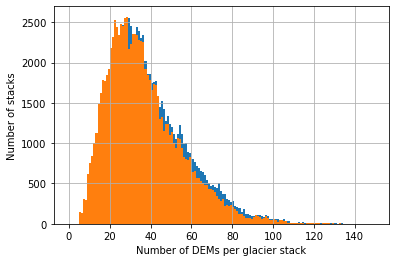

In [69]:
ax = combined_count_df['stack_count'].hist(bins=np.arange(0,150))
aster_count_df['stack_count'].hist(bins=np.arange(0,150))
ax.set_xlabel("Number of DEMs per glacier stack")
ax.set_ylabel("Number of stacks")

In [70]:
combined_count_df['aster_stack_count'] = aster_count_df['stack_count']

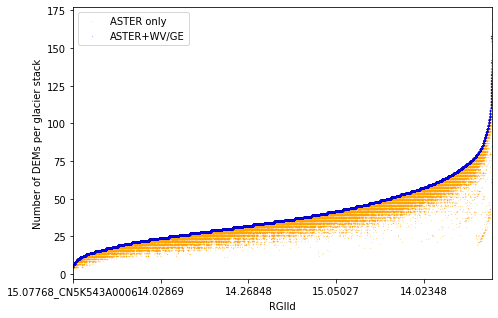

In [71]:
f,ax = plt.subplots(figsize=(7.5,5))
combined_count_df.sort_values(by='stack_count')['aster_stack_count'].plot(ax=ax, color='orange', lw=0, marker='.', ms=0.2, label='ASTER only')
combined_count_df.sort_values(by='stack_count')['stack_count'].plot(ax=ax, color='blue', lw=0, marker='.', ms=0.2, label='ASTER+WV/GE')
ax.set_ylabel("Number of DEMs per glacier stack")
plt.legend(loc='upper left')

In [72]:
combined_count_df['diff'] = combined_count_df['stack_count'] - combined_count_df['aster_stack_count']

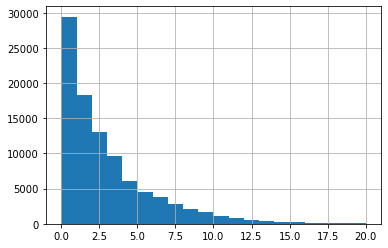

In [78]:
combined_count_df['diff'].hist(bins=20, range=(0,20))

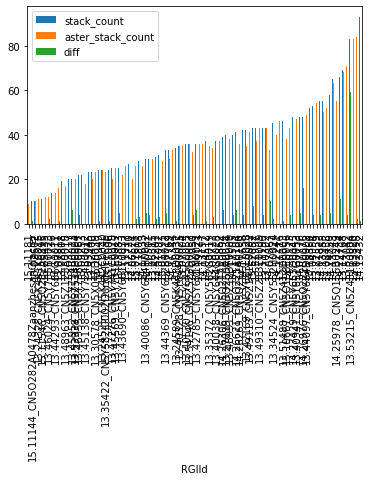

In [80]:
combined_count_df.sample(100).sort_values(by='stack_count').plot.bar()

## Total glacier area covered

In [30]:
#MB total area
mb_area = glac_df_mb.area.sum()/1E6
#RGI total area
rgi_area = glac_df['Area'].sum()
#rgi_area = glac_df.area.sum()/1E6
print('MB area: %0.2f km^2' % mb_area)
print('RGI area: %0.2f km^2' % rgi_area)
print('Percent coverage: %0.2f%%' % (100*mb_area/rgi_area))

MB area: 97002.70 km^2
RGI area: 97300.12 km^2
Percent coverage: 99.69%


In [31]:
#Total RGI glacier count
rgi_count = 95608 - 72 #some RGI 10 included in our gpkg
mb_count = glac_df_mb.shape[0]
print('MB count: %i' % mb_count)
print('RGI count: %i' % rgi_count)
print('Percent coverage: %0.2f%%' % (100*mb_count/rgi_count))

MB count: 94436
RGI count: 95536
Percent coverage: 98.85%


## Sort by area

In [32]:
glac_df_mb_sort = glac_df_mb.sort_values(by='area_m2', ascending=False)

(-2, 2)

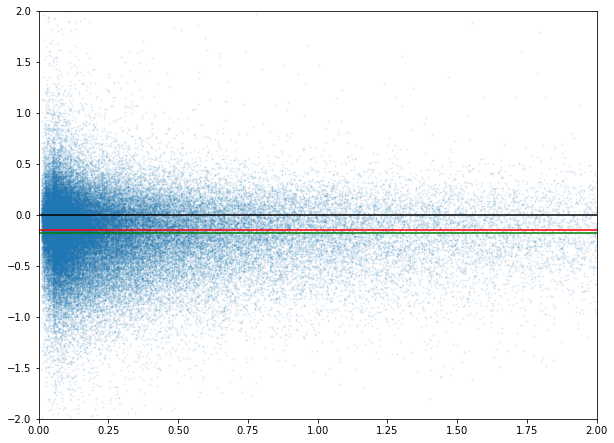

In [33]:
f,ax = plt.subplots(figsize=(10,7.5))
ax.scatter(glac_df_mb['Area'], glac_df_mb['mb_mwea'], s=1, alpha=0.1)
ax.axhline(0,c='k')
ax.axhline(glac_df_mb['mb_mwea'].median(),c='r')
ax.axhline(glac_df_mb['mb_mwea'].mean(),c='g')
ax.set_xlim(0,2)
ax.set_ylim(-2, 2)

(0, 100)

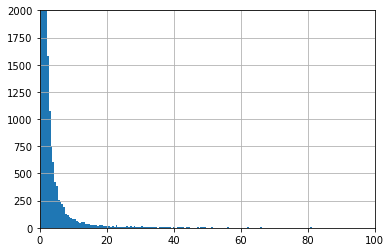

In [34]:
ax = glac_df_mb['Area'].hist(bins=2000)
ax.set_ylim(0,2000)
ax.set_xlim(0,100)

(-10000000.0, 10000000.0)

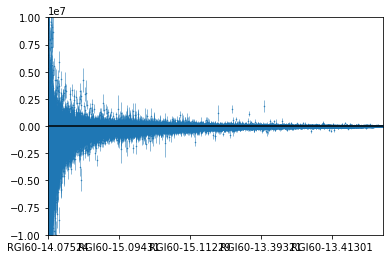

In [35]:
#Plot mb and error for all glaciers, sorted by area
f, ax = plt.subplots()
glac_df_mb_sort['mb_m3wea'].plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'], ax=ax)
ax.axhline(0, color='k', zorder=99)
ax.set_ylim(-0.1E8, 0.1E8)

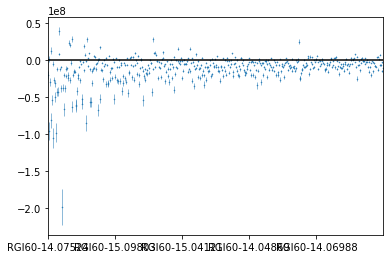

In [36]:
f, ax = plt.subplots()
cutoff = 500
glac_df_mb_sort['mb_m3wea'].head(cutoff).plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'].head(cutoff), ax=ax)
ax.axhline(0, color='k', zorder=99)

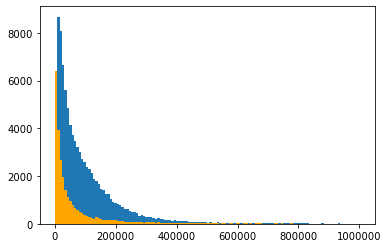

In [37]:
f, ax = plt.subplots()
asdf = ax.hist(glac_df_mb['mb_m3wea_sigma'], bins=128, range=(0,1E6))
asdf = ax.hist(glac_df_mb['mb_m3wea'], bins=128, range=(0,1E6), color='orange')
#mb_df['mb_m3wea'].hist(bins=128, range=(0,1E6),ax=ax)

In [38]:
idx = slice(0,100000)
print(glac_df_mb['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb['mb_m3wea_sigma'][idx].sum()/1E9)

-18.975358849018004
0.08059568665708697
10.541023129204001


In [39]:
def mb_hist(df, col='mb_mwea', hist_clim=(-1.5, 1.5), outlier_clim=None):
    f, ax = plt.subplots(figsize=(4,4))
    ax.set_xlabel('Mass balance (m we/yr)')
    ax.set_ylabel('Number of glaciers')
    ax.set_xlim(*hist_clim)
    df[col].hist(range=hist_clim, bins=64, grid=False)
    ax.axvline(0, lw=0.5, color='k')
    if outlier_clim is not None:
        ax.axvline(outlier_clim[0], lw=1.0, color='r', ls=':')
        ax.axvline(outlier_clim[1], lw=1.0, color='r', ls=':')
    ax.minorticks_on()
    return ax

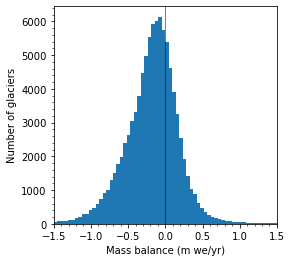

In [40]:
ax = mb_hist(glac_df_mb)

## Remove Outliers

Removing outliers
-6.29
13.287
Removing outliers (-2.84, 2.84)
94436 records before outlier removal
94389 records after outlier removal


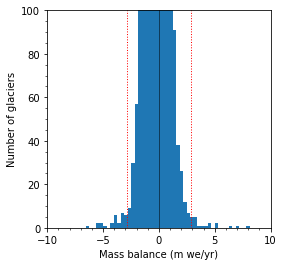

In [42]:
remove_outliers = True
if remove_outliers:
    print("Removing outliers")

    print(glac_df_mb['mb_mwea'].min())
    print(glac_df_mb['mb_mwea'].max())
    
    if False:
        #outlier_perc = (0.01, 0.99)
        outlier_perc = (0.0001, 0.9999)
        outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    else:
        std_f = 7
        outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
        #outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
        outlier_clim = (outlier_clim, -outlier_clim)
    
    ax = mb_hist(glac_df_mb, hist_clim=(-10,10), outlier_clim=outlier_clim)
    ax.set_ylim(0,100)
    
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    print("%i records after outlier removal" % (glac_df_mb[inlier_idx].shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]

# Spatial autocorrelation factor Acorf vs. glacier area A
A quick look at the coefficient used to scale area 

785398.1633974483


Text(0, 0.5, 'Acorf')

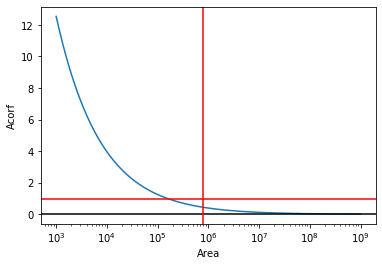

In [670]:
areaa = np.logspace(3, 9, 100)
L = 500
Acor = np.pi*(L**2)
print(Acor)
Acorf = np.sqrt(Acor/(5*areaa))
f,ax = plt.subplots()
ax.semilogx(areaa, Acorf)
ax.axhline(1.0, color='r')
ax.axhline(0.0, color='k')
ax.axvline(Acor, color='r')
ax.set_xlabel('Area')
ax.set_ylabel('Acorf')

## Binned mb by glacier polygon area

In [83]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb['Area'], glac_df_mb['mb_mwea'], statistic=malib.mad, bins=bins)

In [84]:
#bin_width = (bin_edges[1] - bin_edges[0])
#bin_centers = bin_edges[1:] - bin_width/2
bin_width = (bin_edges[:-1] - bin_edges[1:])
bin_centers = bin_edges[:-1] - bin_width/2

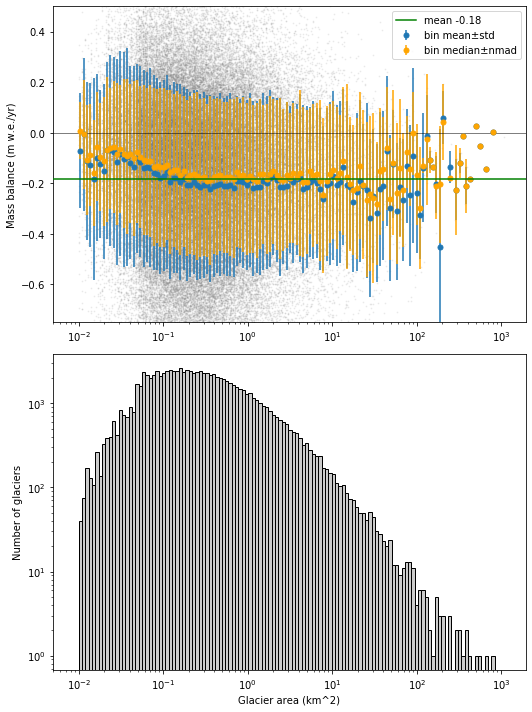

In [85]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(glac_df_mb['Area'], glac_df_mb['mb_mwea'], s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb['mb_mwea'].median(),c='r')
axa[0].axhline(glac_df_mb['mb_mwea'].mean(),c='g',zorder=999, label='mean %0.2f' % glac_df_mb['mb_mwea'].mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k', facecolor='0.8')
#axa[1].bar(bin_centers, bin_count, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e./yr)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Number of glaciers')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
#f.savefig(fig_fn, **plt_opt)

## Consider total mb for small and large glaciers

In [43]:
area_thresh = 0.1 #km2
small_idx = glac_df_mb['Area'] < area_thresh
big_idx = glac_df_mb['Area'] >= area_thresh

In [44]:
print(glac_df_mb['mb_mwea'][small_idx].mean())
print(glac_df_mb['mb_mwea'][small_idx].median())
print(glac_df_mb['mb_m3wea'][small_idx].sum()/1E9)
print(glac_df_mb['Area'][small_idx].sum())

-0.13279346399868788
-0.105
-0.206847295014
1448.8449999999998


In [45]:
print(glac_df_mb['mb_mwea'][big_idx].mean())
print(glac_df_mb['mb_mwea'][big_idx].median())
print(glac_df_mb['mb_m3wea'][big_idx].sum()/1E9)
print(glac_df_mb['Area'][big_idx].sum())

-0.19892844387937317
-0.168
-18.75596663352
95544.57500000001


In [46]:
mb_gt_lt = glac_df_mb['Area'][small_idx].sum()*glac_df_mb['mb_mwea'][small_idx].mean()/1000
mb_gt_lt

-0.19239714634717894

In [47]:
mb_gt_gt = glac_df_mb['Area'][small_idx].sum()*glac_df_mb['mb_mwea'][big_idx].mean()/1000
mb_gt_gt

-0.28821648127241034

In [48]:
# Difference in total mass balance (Gt/yr) if applying specific mass balance from larger glaciers to all glaciers under 0.1 km2
mb_gt_gt - mb_gt_lt

-0.0958193349252314

## Maps of glaciers binned by area

In [147]:
bins=np.logspace(-2,3,11)
bins

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [148]:
df_cut = pd.cut(glac_df_mb['Area'], bins)

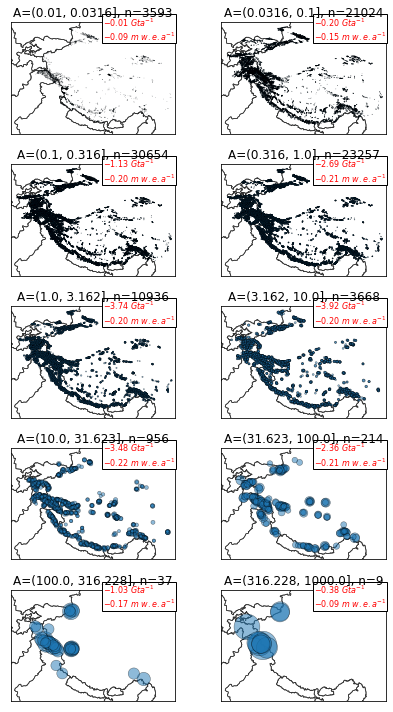

In [149]:
rc = (5,2)
f,axa = plt.subplots(*rc, figsize=(6,10), sharex=True, sharey=True)
axa = axa.ravel()

for n,i in enumerate(glac_df_mb.groupby(df_cut)):
    border_df.plot(ax=axa[n], facecolor='none', edgecolor='0.2', lw=0.7)
    axa[n].scatter(i[1]['x'], i[1]['y'], s=i[1]['Area'], label=i[0], edgecolor='k', lw=0.5, alpha=0.5)
    axa[n].set_title('A=%s, n=%i' % (i[0], i[1].shape[0]))
    mb_gta = i[1]['mb_m3wea'].sum()/1E9
    mb_mwea = i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()
    #mb_label = r'$%0.2f Gta^-1$' % mb_gta
    #axa[n].annotate(mb_label, xy=(0.05, 0.05), xycoords='axes fraction', color='r')
    mb_label = r'$%0.2f\ Gta^{-1}$' % mb_gta +'\n' + '$%0.2f\ m\ w.e.a^{-1}$' % mb_mwea
    #axa[n].annotate(mb_label, xy=(0.01, 0.06), xycoords='axes fraction', color='r', fontsize=8)
    axa[n].text(0.56, 0.84, mb_label, transform=axa[n].transAxes, color='r', fontsize=8, \
    #axa[n].text(0.56, 0.8, mb_label, transform=axa[n].transAxes, color='r', fontsize=7, \
                bbox=dict(facecolor='white', alpha=1.0, edgecolor='k', pad=1.0))
    pltlib.hide_ticks(axa[n])

axa[0].set_xlim(extent[0], extent[2])
axa[0].set_ylim(extent[1], extent[3])
axa[0].set_aspect('equal')

plt.tight_layout()
#plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
f.savefig(fig_fn, **plt_opt)

In [150]:
i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()

-0.08586631367961631

In [151]:
i[1].columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry', 'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag',
       'lat_center', 'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc',
       'lat', 'lon', 'areakm2', 'id', 'left', 'top', 'right', 'bottom',
       'kaab_region', 'himap_region', 'basin_name', 'DN_left', 'ENDO', 'ENDO',
       'DN_right', 'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect',
       'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2',
       'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc',
       'H_m', 'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma',
       'mb_Gta', 'mb_Gta_sigma'],
      dtype='object')

In [152]:
glac_df_mb['mb_m3wea'].groupby(df_cut).agg('sum')/1E9

Area
(0.01, 0.0316]      -0.01
(0.0316, 0.1]       -0.20
(0.1, 0.316]        -1.13
(0.316, 1.0]        -2.69
(1.0, 3.162]        -3.74
(3.162, 10.0]       -3.92
(10.0, 31.623]      -3.48
(31.623, 100.0]     -2.36
(100.0, 316.228]    -1.03
(316.228, 1000.0]   -0.38
Name: mb_m3wea, dtype: float64

## RGI Polygon Date

In [176]:
rgi_decyear=glac_df_mb['BgnDate'].astype(int)/10000
miny = np.floor(rgi_decyear.min())
maxy = np.ceil(rgi_decyear.max())
print(miny, maxy)

1998.0 2014.0


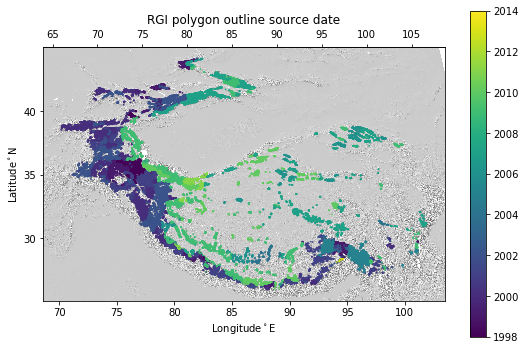

In [50]:
f,ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(glac_df_mb['x'], glac_df_mb['y'], c=rgi_decyear, s=0.5, vmin=miny, vmax=maxy)
plt.colorbar(sc)
ax.set_title("RGI polygon outline source date")
ax.set_aspect('equal', adjustable='box')
add_hs(hs, ax, hs_clim, hs_extent_cartopy)
pltlib.latlon_ticks(ax, in_crs=glac_crs)

#glac_df_mb.plot.scatter(x='x', y='y', c='BgnDate')
rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_RGI_sourceyear_fig.png'
f.savefig(rgi_date_fig_fn, **plt_opt)

In [51]:
# Check min/max mass numbers
rgi_idx = [glac_df_mb['mb_m3wea'].idxmax(),]
rgi_idx.append(glac_df_mb['mb_m3wea'].idxmin())
glac_df_mb.loc[rgi_idx]

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGI60-14.04404  G075438E36192N  19980813  -9999999   75.44   36.19       14   
RGI60-15.11909  G096657E29334N  20050908  -9999999   96.66   29.33       15   

               O2Region   Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax  \
RGI60-14.04404        2 203.34  3314  7718  5391  23.60      21  31640   
RGI60-15.11909        3 179.59  3980  6341  5207  12.90      78  32403   

                Status  Connect  Form  TermType  Surging  Linkages  \
RGI60-14.04404       0        0     0         0        3         9   
RGI60-15.11909       0        0     1         0        1         9   

                             Name  \
RGI60-14.04404  Khurdopin Glacier   
RGI60-15.11909            Yagnung   

                                                         geometry  mascon  \
RGI60-14.04404  POLYGON ((-832770.2283471222 56816.06814658215...  36N76E   
RGI60-15.11909  POLYGON ((1108921.644128018 -679012.9025896977...  29N97E   

                area_deg  area_km2    basin  elev_flag  lat_center  lat_span  \
RGI60-14.04404      1.00 12,373.54 5,051.00       0.00       36.00      1.00   
RGI60-15.11909      1.00 12,406.28 5,035.00       0.00       29.00      1.00   

                location  lon_center  lon_span      qdgc    lat    lon  \
RGI60-14.04404     80.00       76.08      1.24  E075N36C  36.25  75.25   
RGI60-15.11909     80.00       96.88      1.15  E096N29D  29.25  96.75   

                   areakm2     id         left         top        right  \
RGI60-14.04404  2493.27629   2985  -842,814.95   71,740.08  -813,947.44   
RGI60-15.11909  2693.48103  11025 1,105,742.21 -678,259.92 1,134,609.72   

                    bottom     kaab_region     himap_region   basin_name  \
RGI60-14.04404   46,740.08       Karakoram        Karakoram        Indus   
RGI60-15.11909 -703,259.92  Nyainqentangla  Nyainqentanglha  Brahmaputra   

                DN_left  ENDO  ENDO  DN_right            x           y  \
RGI60-14.04404     5367     0     0        51  -838,312.43   62,425.23   
RGI60-15.11909       21     0     0        51 1,117,064.38 -685,115.41   

                  z_med    z_min    z_max  z_slope  z_aspect  dhdt_ma  \
RGI60-14.04404 5,369.00 3,295.32 7,510.49    15.66    143.91     0.23   
RGI60-15.11909 5,166.14 3,921.18 6,317.99     9.99    116.07    -1.30   

                dhdt_ma_sigma  mb_mwea  mb_mwea_sigma        area_m2  \
RGI60-14.04404           0.01     0.20           0.06 203,335,845.65   
RGI60-15.11909           0.01    -1.10           0.09 179,589,230.18   

                      mb_m3wea  mb_m3wea_sigma       t1       t2    dt  \
RGI60-14.04404   39,691,132.12    5,224,127.20 2,000.41 2,018.41 18.00   
RGI60-15.11909 -198,383,836.77   24,336,811.74 2,000.41 2,018.41 18.00   

                valid_area_perc    H_m  debris_m  perc_debris  perc_pond  \
RGI60-14.04404           100.00 142.66      0.18        15.82       0.45   
RGI60-15.11909            99.96 171.93      0.14        10.37       0.13   

                perc_clean  vm_ma  mb_Gta  mb_Gta_sigma  
RGI60-14.04404       83.72  53.99    0.04          0.01  
RGI60-15.11909       89.51  61.99   -0.20          0.02

In [52]:
#mb_m3wea_sigma_thresh = glac_df_mb['mb_m3wea_sigma'].quantile(0.99)
#glac_df_mb = glac_df_mb[glac_df_mb['mb_m3wea_sigma'] < mb_m3wea_sigma_thresh]

In [53]:
#Evaluate SNR
glac_df_mb['SNR'] = glac_df_mb['mb_m3wea'].abs()/glac_df_mb['mb_m3wea_sigma']

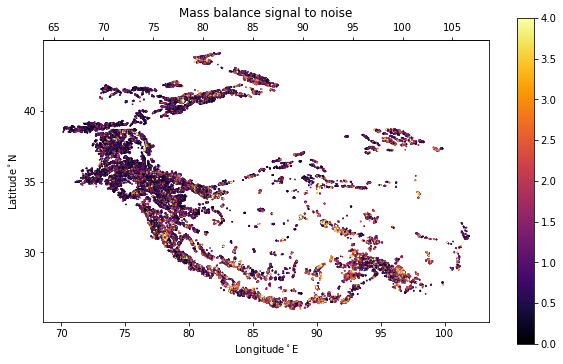

In [54]:
f,ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(glac_df_mb['x'], glac_df_mb['y'], c=glac_df_mb['SNR'], s=0.5, cmap='inferno', vmin=0, vmax=4)
plt.colorbar(sc)
ax.set_aspect('equal')
ax.set_title("Mass balance signal to noise")
pltlib.latlon_ticks(ax, in_crs=glac_crs)
#glac_df_mb.plot.scatter(x='x', y='y', c='BgnDate')
#rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_SNR_fig.png'
#f.savefig(rgi_date_fig_fn, **plt_opt)

# Aggregation with 25-km hexagon bins

In [55]:
if hex_shp_fn is not None:
    glac_df_mb_hex = spatial_aggregate(glac_df, glac_df_mb, hex_df, hex_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [56]:
#glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_df.geometry)
from shapely.geometry import Point
hex_geom = [Point(p) for p in zip(glac_df_mb_hex['centroid_x'], glac_df_mb_hex['centroid_y'])]
glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_geom)

In [57]:
#Note, some nan values for some columns here
glac_df_mb_hex.head()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                           
3434    72,021,266.76 1,080,319,001.34            -0.07              -0.09   
3255    12,300,046.32   910,203,428.02             0.03               0.02   
1904    26,353,797.16   764,260,117.65            -0.03              -0.04   
2986    18,000,865.03   630,030,276.20            -0.08              -0.07   
2897     9,305,746.59   614,179,274.66            -0.08              -0.06   

      (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
id                                                                             
3434            0.14           -1.08            15.00                   0.21   
3255            0.34            2.08            74.00                   0.33   
1904            0.17           -0.84            29.00                   0.24   
2986            0.47           -2.67            35.00                   0.37   
2897            0.22           -5.28            66.00                   0.29   

      (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
id                                                                   
3434                  3.11                  0.89     -1,321,198.82   
3255                 24.43                  3.40         87,838.03   
1904                  6.85                  1.47     -3,204,054.59   
2986                 12.89                  2.57     -1,056,121.04   
2897                 19.10                  2.69        114,579.89   

      (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
id                                                                  
3434           -3,871.67   -19,817,982.27              384,108.26   
3255            3,180.16     6,500,014.03              162,636.54   
1904          -12,294.99   -92,917,583.03              532,240.62   
2986          -14,682.09   -36,964,236.45              243,235.52   
2897          -10,427.57     7,562,273.00              172,280.94   

      (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
id                                                                          
3434           5,761,623.90           5,369,394.75           1,386,371.76   
3255          12,035,103.68           4,576,280.15             531,981.76   
1904          15,434,978.11          12,179,049.64           2,261,592.74   
2986           8,513,243.14           4,998,436.84             844,890.03   
2897          11,370,541.87           4,724,259.72             581,516.17   

      (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
id                                                               
3434          -0.02                  0.00                 0.01   
3255           0.01                  0.00                 0.01   
1904          -0.09                  0.00                 0.02   
2986          -0.04                  0.00                 0.01   
2897           0.01                  0.00                 0.01   

      (mb_Gta_sigma, rss)  (mb_Gta_sigma, rms)  (Area, mean)  (Area, sum)  \
id                                                                          
3434                 0.01                 0.00         72.02     1,080.32   
3255                 0.00                 0.00         12.30       910.21   
1904                 0.01                 0.00         26.35       764.26   
2986                 0.00                 0.00         18.00       630.03   
2897                 0.00                 0.00          9.31       614.18   

      (t1, mean)  (t1, amin)  (t1, amax)  (t2, mean)  (t2, amin)  (t2, amax)  \
id                                                                             
3434    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
3255    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1904    2,000.41    2,000.41    2,000.41    2,018.41    2,01

In [58]:
glac_df_mb_hex.dropna(axis=0, how='any').shape

(2248, 62)

In [59]:
glac_df_mb_hex.describe()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
count         2,422.00         2,422.00         2,422.00           2,422.00   
mean        854,179.17    40,046,794.08            -0.21              -0.22   
std       2,147,307.97    73,104,302.63             0.27               0.27   
min          16,729.86        16,729.86            -1.83              -1.79   
25%         211,925.53     1,982,509.00            -0.36              -0.38   
50%         418,149.34    12,281,289.61            -0.18              -0.19   
75%         850,802.01    47,356,194.98            -0.03              -0.03   
max      72,021,266.76 1,080,319,001.34             0.76               0.76   

       (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
count        2,287.00        2,422.00         2,422.00               2,422.00   
mean             0.25           -7.09            38.97                   0.28   
std              0.14           13.45            36.24                   0.14   
min              0.00         -101.69             1.00                   0.03   
25%              0.16          -10.41             9.00                   0.18   
50%              0.22           -2.88            28.00                   0.25   
75%              0.30           -0.24            62.00                   0.34   
max              1.04           43.05           190.00                   1.20   

       (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
count              2,422.00              2,422.00          2,422.00   
mean                  10.26                  1.60       -167,470.46   
std                   10.83                  1.17        422,120.19   
min                    0.03                  0.03     -7,581,802.32   
25%                    2.01                  0.70       -204,182.26   
50%                    6.83                  1.37        -77,332.94   
75%                   15.23                  2.19        -15,968.12   
max                   78.11                  9.11      1,531,037.07   

       (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
count            2,422.00         2,422.00                2,422.00   
mean           -49,712.28    -7,829,402.94               98,074.81   
std             95,694.06    20,189,293.76               83,420.97   
min         -2,294,873.86  -272,944,883.39                2,631.96   
25%            -77,809.14    -8,148,870.40               49,874.38   
50%            -29,296.32    -1,456,657.97               79,142.81   
75%             -4,071.46       -88,559.28              119,697.10   
max            583,912.50    83,692,166.54            1,263,635.74   

       (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
count               2,422.00               2,422.00               2,422.00   
mean            4,347,061.05             926,650.42             146,760.35   
std             5,445,705.91           1,349,550.29             194,713.06   
min                 3,224.89               3,224.89               2,750.10   
25%               474,507.66             209,269.45              63,466.66   
50%             2,179,016.39             541,125.97             102,512.49   
75%             6,476,365.01           1,130,321.54             163,865.01   
max            45,490,886.76          25,686,021.93           4,281,003.66   

       (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
count       2,422.00              2,422.00             2,422.00   
mean           -0.01                  0.00                 0.00   
std             0.02                  0.00                 0.01   
min            -0.27                  0.00                 0.00   
25%            -0.01                  0.00                 0.00   
50%            -0.00                  0.00                 0.00   
75%            -0.00                  0.00                 0.01   
max             0.08                  0.00             

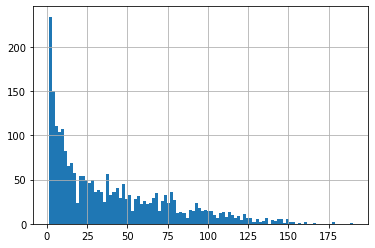

In [60]:
glac_df_mb_hex[('mb_mwea', 'size')].hist(bins=100)

In [61]:
# Count of glaciers in hex bins
print(glac_df_mb_hex[('mb_mwea', 'size')].mean())
print(glac_df_mb_hex[('mb_mwea', 'size')].min())
print(glac_df_mb_hex[('mb_mwea', 'size')].max())

38.971511147811725
1.0
190.0


## Check for outliers

In [62]:
def hex_check(glac_df_mb_hex, col=('mb_Gta', 'sum')):
    f,axa = plt.subplots(1,2, figsize=(8,4))
    glac_df_mb_hex[col].hist(ax=axa[0], bins=100)
    axa[0].set_ylim(0,10)
    axa[0].set_xlabel(col)
    axa[0].set_ylabel("Number of hex bins")
    axa[0].axvline(0, color='k')
    axa[1].scatter(glac_df_mb_hex[('mb_mwea', 'count')], glac_df_mb_hex[col])
    axa[1].set_xlabel("Number of glaciers in hex bin")
    axa[1].set_ylabel(col)
    axa[1].axhline(0, color='k')
    plt.tight_layout()

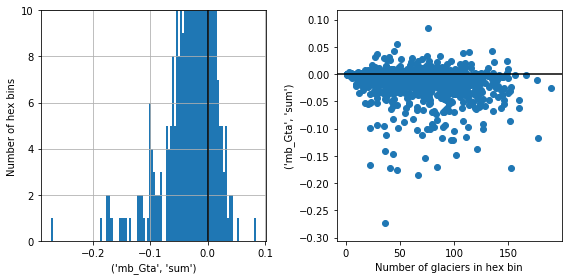

In [63]:
hex_check(glac_df_mb_hex, col=('mb_Gta', 'sum'))

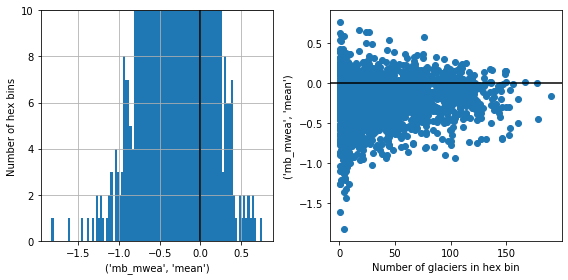

In [64]:
hex_check(glac_df_mb_hex, col=('mb_mwea', 'mean'))

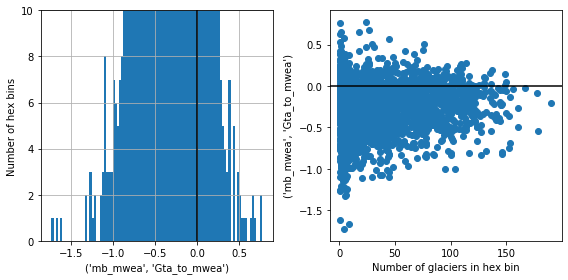

In [65]:
hex_check(glac_df_mb_hex, col=('mb_mwea', 'Gta_to_mwea'))

In [66]:
if False:
    outlier_clim = (-0.20, 0.08)
    col = ('mb_Gta', 'sum')
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    inlier_idx = (glac_df_mb_hex[col] >= outlier_clim[0]) & (glac_df_mb_hex[col] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb_hex.shape[0]))
    print("%i records after outlier removal" % (glac_df_mb_hex[inlier_idx].shape[0]))
    glac_df_mb_hex = glac_df_mb_hex[inlier_idx]

## HMA-wide numbers

In [67]:
#Sum of all hex samples - full region mb and uncertainty
hma_stats = glac_df_mb_hex.sum(axis=0)
hma_stats

(area_m2, mean)                   2,068,821,952.91
(area_m2, sum)                   96,993,335,269.14
(mb_mwea, mean)                            -514.19
(mb_mwea, median)                          -525.10
(mb_mwea, std)                              561.21
                                       ...        
(meltwater_cum, total_m3)      -408,810,134,881.64
(meltwater_cum, total_Gt)                  -408.81
(meltwater_cum, total_mmSLE)               -408.81
centroid_x                         -336,598,969.13
centroid_y                         -184,445,517.18
Length: 61, dtype: float64

In [68]:
print('%0.2f\u00b1%0.2f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))

-18.96±2.24 Gt/yr
-19.0±2.2 Gt/yr


In [69]:
print('%0.3f\u00b1%0.3f mmSLE/yr' % (hma_stats[('mb_Gta', 'sum')]/Gt2mm, hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.052±0.006 mmSLE/yr


In [70]:
dt = 18.0
print('%0.3f\u00b1%0.3f mmSLE' % (dt*hma_stats[('mb_Gta', 'sum')]/Gt2mm, dt*hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.942±0.111 mmSLE


In [71]:
print('%0.2f\u00b1%0.2f Gt' % (dt*hma_stats[('mb_Gta', 'sum')], dt*hma_stats[('mb_Gta_sigma', 'rss')]))

-341.33±40.40 Gt


In [72]:
hma_stats_m = 1000*hma_stats/hma_stats[('Area', 'sum')]
print('%0.2f\u00b1%0.2f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))

-0.20±0.02 m we/yr
-0.2±0.0 m we/yr


## Plot hex grids

In [171]:
title = suptitle + ": 25-km Hex Grid Cells"
extent = [-1610900, -1142400, 1767400, 1145700]

In [172]:
scaling_f = 0.2
cbar_fmt = '%0.2f'

Plotting image
Plotting borders
Plotting scatterplot of ('mb_Gta', 'sum') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_Gta_sigma', 'sum') values


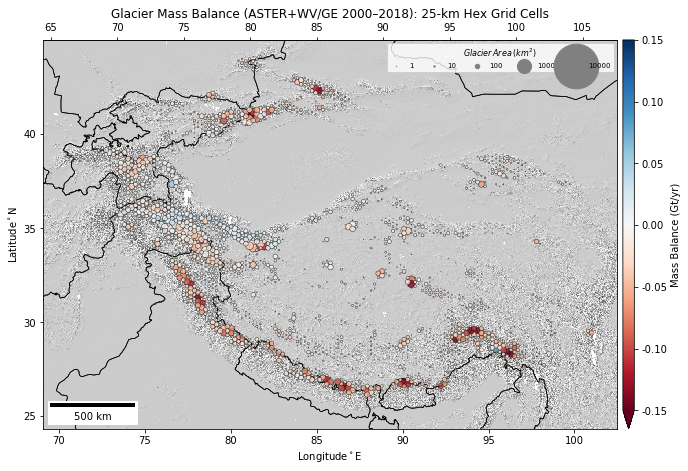

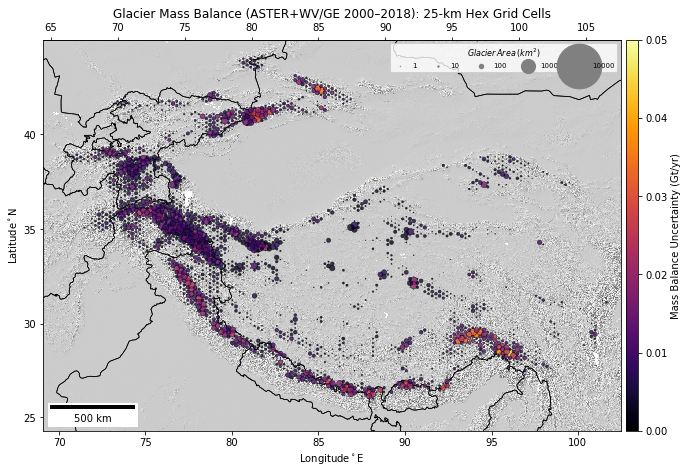

In [173]:
out_fn_suffix = '_hex_mb_Gta'
mb_gt_clim = (-0.15,0.15)
#hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs=hs, hs_extent_cartopy=hs_extent_cartopy, labels=None, title=title)
hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs_bg=True, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_gt_sigma_clim = (0.00,0.05)
hex_sigma_fig = make_map(col=('mb_Gta_sigma', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'mean') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'mean') values


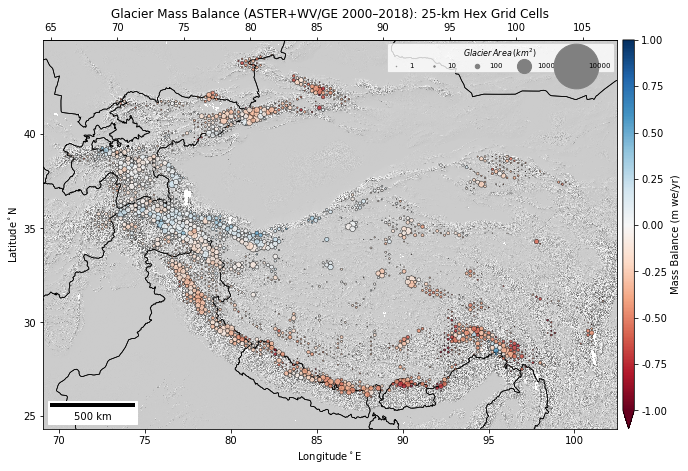

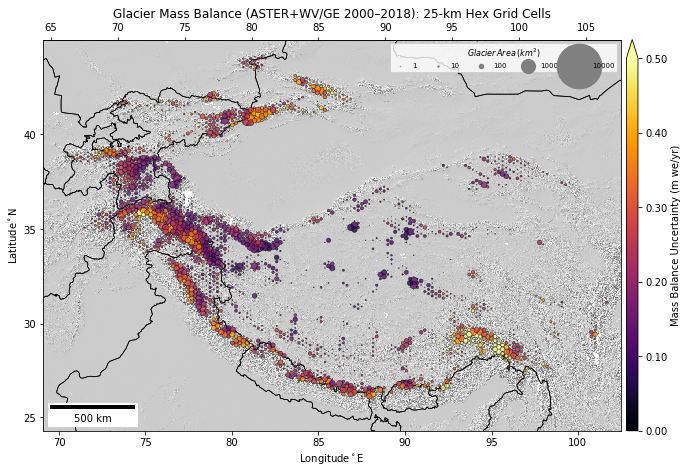

In [174]:
out_fn_suffix = '_hex_mb_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'Gta_to_mwea') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'Gta_to_mwea') values


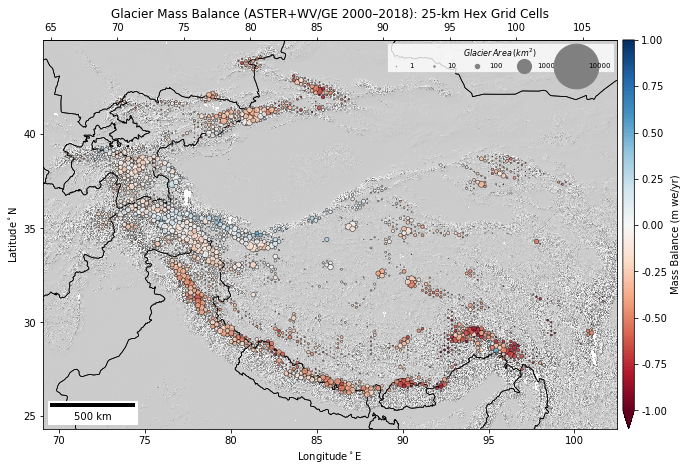

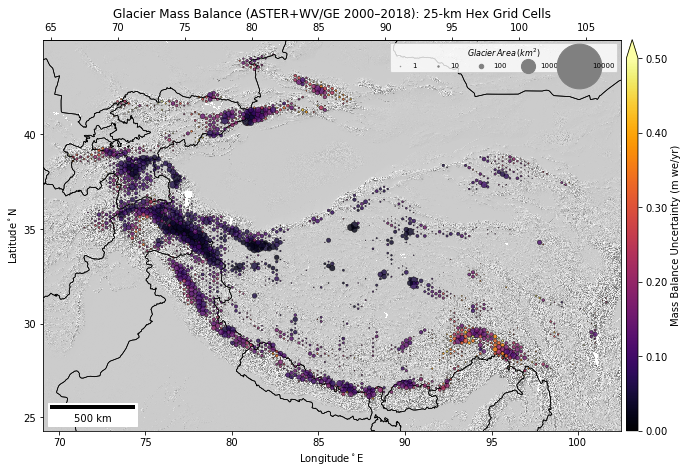

In [175]:
out_fn_suffix = '_hex_mb_Gta_to_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title, cbar_fmt=cbar_fmt)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

## Exploring mb vs elevation

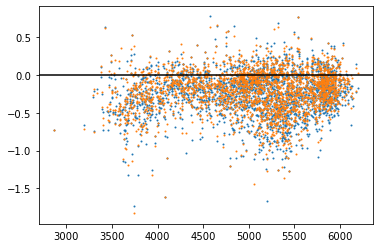

In [81]:
f,ax = plt.subplots()
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
mb2=glac_df_mb_hex[('mb_mwea', 'mean')]
#mb=glac_df_mb_hex[('mb_Gta', 'sum')]

ax.scatter(z,mb,s=1)
ax.scatter(z,mb2,s=1)
ax.axhline(0,c='k')
#ax.set_ylim(-0.1, 0.05)

In [82]:
def norm(a, percentile=(0.5, 99.5)):
    #amin, amax = (a.min(), a.max())
    amin, amax = np.nanpercentile(a, percentile)
    print(amin, amax)
    return ((a - amin)/(amax - amin))

-1.1321344828436877 0.47651632140634054
3425.31845 6092.043895


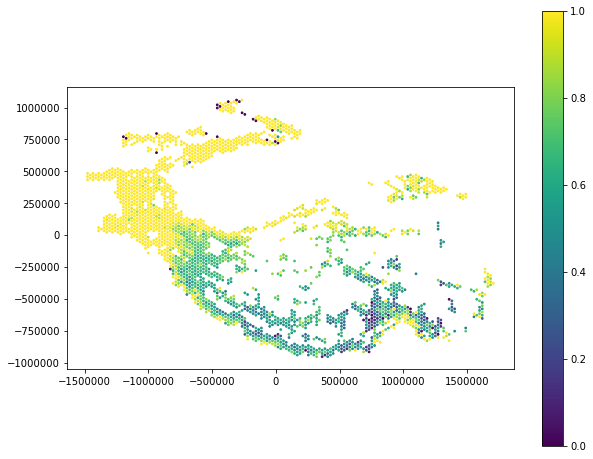

In [83]:
f,ax = plt.subplots(figsize=(10,8))
x=glac_df_mb_hex['centroid_x'].values
y=glac_df_mb_hex['centroid_y'].values
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#mb=glac_df_mb_hex[('mb_mwea', 'mean')]
#asdf = norm(mb/z)
asdf = norm(mb)/norm(z)
clim=(0,1)
sc = ax.scatter(x,y,c=asdf,s=3,vmin=clim[0],vmax=clim[1])
plt.colorbar(sc)
ax.set_aspect('equal')

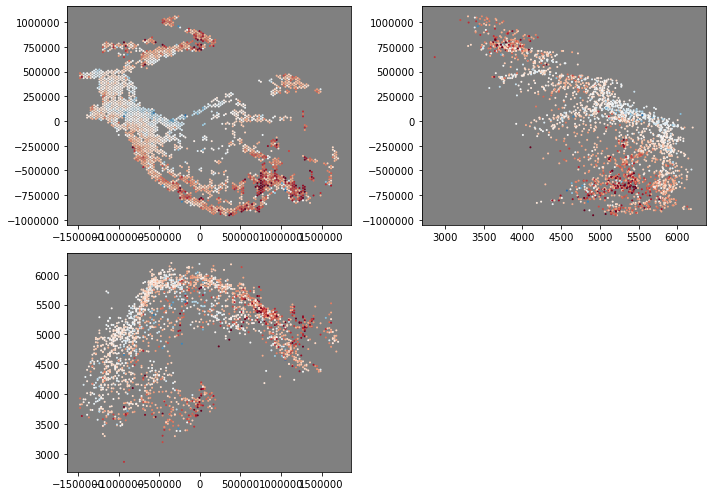

In [84]:
f,axa = plt.subplots(2,2,figsize=(10,7))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
axa[0][0].scatter(x,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][0].scatter(x,z,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[0][1].scatter(z,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][1].axis('off')
plt.tight_layout()
for ax in axa.ravel():
    ax.set_facecolor('0.5')

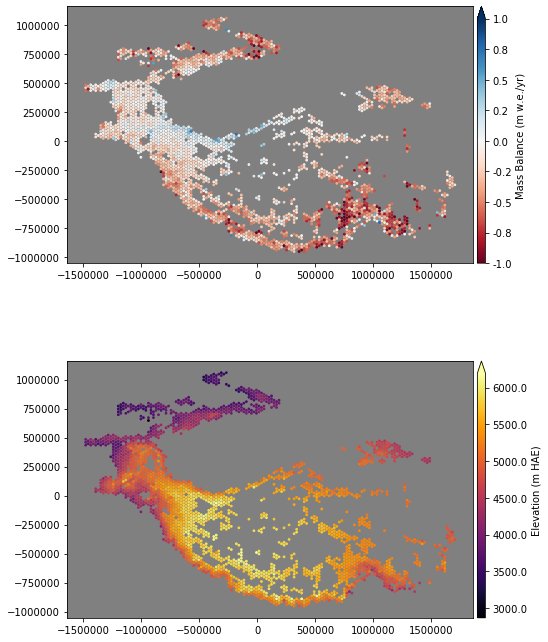

In [85]:
f,axa = plt.subplots(2, figsize=(7.5,10))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
mb_m = axa[0].scatter(x,y,c=mb,s=3,vmin=clim[0],vmax=clim[1],cmap='RdBu')
z_m = axa[1].scatter(x,y,c=z,s=3,cmap='inferno')
pltlib.add_cbar(axa[0], mb_m, label='Mass Balance (m w.e./yr)')
pltlib.add_cbar(axa[1], z_m, label='Elevation (m HAE)')

for ax in axa.ravel():
    ax.set_aspect('equal')
    ax.set_facecolor('0.5')
plt.tight_layout()

## Aggregation of hex cells over regions and basins

In [86]:
def hex_agg(glac_gdf_mb_hex, region_df, region_col):
    print("One-time spatial join by hex")
    glac_gdf_mb_hex_region = gpd.sjoin(glac_gdf_mb_hex, region_df, how="inner", op="within")
    glac_gdf_mb_hex_region.rename(index=str, columns={'index_right':region_col}, inplace=True)
    print(glac_gdf_mb_hex_region.shape)
    
    aggfunc = { ('mb_m3wea_sigma', 'sum'):[np.sum, rss, rms], \
               ('mb_m3wea', 'sum'):[np.sum, np.size], \
               ('z_med', 'median'):[np.mean, np.median], \
              ('Area_all', 'sum'):[np.sum],\
              ('meltwater', 'total_m3a'):[np.sum], \
               ('meltwater', 'total_m3a_sigma'):[np.sum, rss, rms]}
    
    #print(glac_gdf_mb_hex_region.columns)
    
    glac_gdf_mb_hex_region_agg = glac_gdf_mb_hex_region.groupby(region_col).agg(aggfunc)
    glac_gdf_mb_hex_region_agg_melt = glac_gdf_mb_hex_region[glac_gdf_mb_hex_region[('meltwater', 'total_Gta')] < 0].groupby(region_col).agg(aggfunc)
    
    glac_gdf_mb_hex_region_agg['centroid_x'] = region_df['centroid_x']
    glac_gdf_mb_hex_region_agg['centroid_y'] = region_df['centroid_y']
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_df_mb_region[('Area_all', 'sum')
    glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_mwea','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('mb_mwea_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('meltwater_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a_sigma','rss')]/1E9

    if 'ENDO' in region_df:
        glac_gdf_mb_hex_region_agg['ENDO'] = region_df['ENDO']
    
    #glac_gdf_mb_hex_region_agg.sort_values(by=('Area_all', 'sum', 'sum'), ascending=False, inplace=True)
    glac_gdf_mb_hex_region_agg.sort_values(by='centroid_x', ascending=True, inplace=True)
    
    return glac_gdf_mb_hex_region_agg

In [87]:
#Fix incorrect spellings in Kaab regions
kaab_region_df.rename({'Nyainqentangla':'Nyainqentanglha', 'Pamir Alai':'Pamir Alay'}, inplace=True)

In [89]:
mb_unit = 'Gta'
region_clim = (-3.5, 3.5)
ylim = (-4.5, 1.5)
col=('mb_Gta', 'sum', 'sum')
sigma_col=('mb_Gta_sigma', 'sum', 'rss')

In [152]:
mb_unit = 'mwea'
region_clim = (-0.5, 0.5)
ylim = (-0.70, 0.15)
col=('mb_mwea', 'sum', 'sum')
sigma_col=('mb_mwea_sigma', 'sum', 'rss')

In [153]:
def hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, out_fn_suffix, clim=None, \
                col=col, sigma_col=sigma_col, map=True, hs_bg=True):
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    y_label = 'Mass Balance (Gt/yr)'
    if 'mb_mwea' in col:
        y_label = 'Mass Balance (m we/yr)'

    #Add Brun et al. bars if present
    if 'orig_mb_mwea' in glac_gdf_mb_hex_region_agg:
        if 'mb_mwea' in col:
            col_idx = [col,'new_mb_mwea']
            sigma_col_idx = [sigma_col,'new_mb_err_mwea']
        else:
            col_idx = [col,'new_mb_gta']
            sigma_col_idx = [sigma_col,'new_mb_err_gta']
        color=['darkorange','0.8']
    else:
        col_idx = col
        sigma_col_idx = sigma_col
        color='darkorange'
        
    mb_tot = glac_gdf_mb_hex_region_agg[col_idx]
    err = glac_gdf_mb_hex_region_agg[sigma_col_idx]
    
    if 'orig_mb_mwea' in glac_gdf_mb_hex_region_agg:
        colnames=["This Study", "Brun et al. (2017)"]
        mb_tot.columns = colnames
        err.columns = colnames
    
    width = 1.3*(glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')].max()).values
    
    print(width)
    
    #mb_tot.plot.bar(ax=ax, color=color)
    mb_tot.plot.bar(yerr=err, ax=ax, color=color, edgecolor='k', linewidth=0.5, \
                    error_kw=dict(ecolor='k', lw=0.5, capsize=2.0, capthick=0.5))
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel(y_label)
    ax.set_ylim(*ylim)
    ax.set_xlabel(mb_tot.index.name)
    ax.grid(axis='y', lw=0.5, ls=':')
 
    plt.tight_layout()
    fig_fn = os.path.splitext(glac_shp_join_fn)[0]+ out_fn_suffix + '_bar.png'
    fig.savefig(fig_fn, **plt_opt) 
    #return mb_tot, err
    if map:
        hex_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
        hex_region_fig = make_map(col=col, sigma_col=sigma_col, \
                                  mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=glac_df_mb, \
                                  agg_df=region_df, border_df=border_df, clim=clim, crs=crs, \
                                  extent=extent, labels='name+val+sigma', title=title, hs_bg=hs_bg)
        hex_region_fig.savefig(hex_region_fig_fn, **plt_opt) 

In [154]:
append_centroid_xy(region_df)
append_centroid_xy(kaab_region_df)
append_centroid_xy(basin_df)

In [155]:
def short_lbl(df):
    orig_index_name = df.index.name
    df[orig_index_name+'_orig'] = df.index
    regex_dict = {'Eastern':'E.','East':'E.','Western':'W.','West':'W.','Northern':'N.','Southern':'S.','Central':'C.','Mountains':'Mtns'}
    new_index = df[orig_index_name+'_orig'].replace(regex=regex_dict)
    df.index = new_index
    df.index.name = orig_index_name

In [156]:
region_df.head()
region_df_cp = region_df.copy()
short_lbl(region_df)
region_df.head()

geometry  \
himap_region                                                       
E. Hindu Kush  (POLYGON ((-1007072.451620904 169859.103980618...   
W. Himalaya    (POLYGON ((-821513.7920037253 -39192.895313012...   
E. Himalaya    (POLYGON ((974925.0577844162 -645901.231420908...   
C. Himalaya    (POLYGON ((-384112.099573634 -588849.806896036...   
Karakoram      (POLYGON ((-793139.7461575471 184761.164018728...   

                 centroid_x  centroid_y himap_region_orig  
himap_region                                               
E. Hindu Kush -1,203,427.33   52,490.72     E. Hindu Kush  
W. Himalaya     -794,613.29 -266,517.78       W. Himalaya  
E. Himalaya      646,584.48 -866,752.59       E. Himalaya  
C. Himalaya     -151,474.46 -782,787.79       C. Himalaya  
Karakoram       -781,483.71   19,769.49         Karakoram

In [157]:
kaab_region_df.head()
kaab_region_df_cp = kaab_region_df.copy()
short_lbl(kaab_region_df)
kaab_region_df.head()

geometry  \
kaab_region                                                          
Inner TP         (POLYGON ((-4401.725805810875 124890.025851544...   
Kunlun           (POLYGON ((-1002287.270993384 465136.935820820...   
Pamir Alay       (POLYGON ((-1247293.932661358 322182.736021329...   
Nyainqentanglha  (POLYGON ((693944.8486240985 -732894.492323651...   
C. Himalaya      (POLYGON ((-137023.4274918161 -852014.06355443...   

                   centroid_x  centroid_y kaab_region_orig  
kaab_region                                                 
Inner TP           659,777.94 -187,764.02         Inner TP  
Kunlun            -526,188.79  106,040.12           Kunlun  
Pamir Alay      -1,262,182.12  466,842.59       Pamir Alay  
Nyainqentanglha    966,755.14 -658,278.05  Nyainqentanglha  
C. Himalaya        170,838.01 -850,516.83      C. Himalaya

In [158]:
#Revert
#region_df = region_df_cp
#region_df.set_index('himap_region', inplace=True)
region_df.head()

geometry  \
himap_region                                                       
E. Hindu Kush  (POLYGON ((-1007072.451620904 169859.103980618...   
W. Himalaya    (POLYGON ((-821513.7920037253 -39192.895313012...   
E. Himalaya    (POLYGON ((974925.0577844162 -645901.231420908...   
C. Himalaya    (POLYGON ((-384112.099573634 -588849.806896036...   
Karakoram      (POLYGON ((-793139.7461575471 184761.164018728...   

                 centroid_x  centroid_y himap_region_orig  
himap_region                                               
E. Hindu Kush -1,203,427.33   52,490.72     E. Hindu Kush  
W. Himalaya     -794,613.29 -266,517.78       W. Himalaya  
E. Himalaya      646,584.48 -866,752.59       E. Himalaya  
C. Himalaya     -151,474.46 -782,787.79       C. Himalaya  
Karakoram       -781,483.71   19,769.49         Karakoram

## HiMAP regions

In [159]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": HiMAP Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, region_df, region_col)

One-time spatial join by hex
(2422, 66)


In [160]:
glac_gdf_mb_hex_region_agg.head()

mb_m3wea_sigma                                      mb_m3wea  \
                           sum                                           sum   
                           sum            rss          rms               sum   
himap_region                                                                   
Pamir Alay      317,758,801.47  52,793,245.46 6,221,743.64    -58,653,161.38   
E. Hindu Kush   379,060,406.88  53,285,958.42 5,276,096.08   -295,367,822.35   
W. Pamir        722,306,815.95  75,385,581.31 6,035,676.98   -947,351,232.95   
E. Pamir        151,657,416.08  31,303,442.24 4,471,920.32     43,976,241.16   
W. Himalaya   1,052,179,452.54 108,436,151.20 7,429,922.65 -2,586,870,951.12   

                        z_med          Area_all         meltwater  \
                       median               sum         total_m3a   
                size     mean   median      sum               sum   
himap_region                                                        
Pamir Alay     72.00 4,046.22 4,089.72 1,846.56   -200,394,506.08   
E. Hindu Kush 102.00 4,686.00 4,679.10 2,954.43   -417,117,655.31   
W. Pamir      156.00 4,695.52 4,842.27 8,329.72 -1,132,774,955.63   
E. Pamir       49.00 4,943.90 4,947.09 2,224.63   -137,177,302.79   
W. Himalaya   213.00 5,140.19 5,202.93 8,147.92 -2,691,461,137.08   

                                                            centroid_x  \
              total_m3a_sigma                                            
                          sum           rss          rms                 
himap_region                                                             
Pamir Alay     166,160,289.51 28,304,347.60 3,383,016.60 -1,244,513.89   
E. Hindu Kush  256,766,439.50 36,969,324.25 3,715,556.89 -1,203,427.33   
W. Pamir       515,470,536.47 55,462,094.95 4,454,822.67 -1,091,984.74   
E. Pamir        68,003,881.83 14,562,180.29 2,170,801.67   -837,265.31   
W. Himalaya    905,797,069.91 96,273,733.35 6,612,107.15   -794,613.29   

               centroid_y mb_Gta mb_Gta_sigma mb_mwea mb_mwea_sigma  \
                             sum          sum     sum           sum   
                             sum          rss     sum           rss   
himap_region                                                          
Pamir Alay     484,331.70  -0.06         0.05   -0.03          0.03   
E. Hindu Kush   52,490.72  -0.30         0.05   -0.10          0.02   
W. Pamir       309,369.96  -0.95         0.08   -0.11          0.01   
E. Pamir       322,658.14   0.04         0.03    0.02          0.01   
W. Himalaya   -266,517.78  -2.59         0.11   -0.32          0.01   

              meltwater_Gta meltwater_Gta_sigma  
                        sum                 sum  
                        sum                 rss  
himap_region                                     
Pamir Alay            -0.20                0.03  
E. Hindu Kush         -0.42                0.04  
W. Pamir              -1.13                0.06  
E. Pamir              -0.14                0.01  
W. Himalaya           -2.69                0.10

[0.11206147 0.17929415 0.50550187 0.13500535 0.49446906 0.13350251
 1.3        0.51185885 0.44496013 0.03161023 0.51568034 0.07737856
 0.23254702 0.12528998 0.01791212 0.18175602 0.17339384 0.1117033
 0.42369083 0.01875336 0.09695228 0.08129788]
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


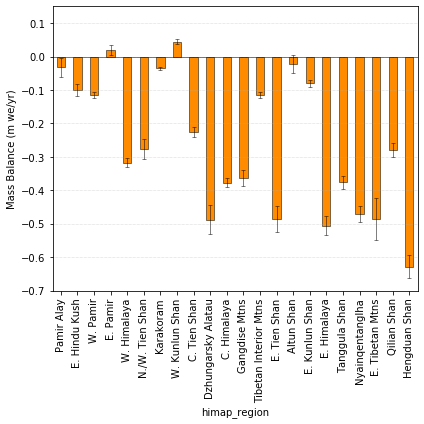

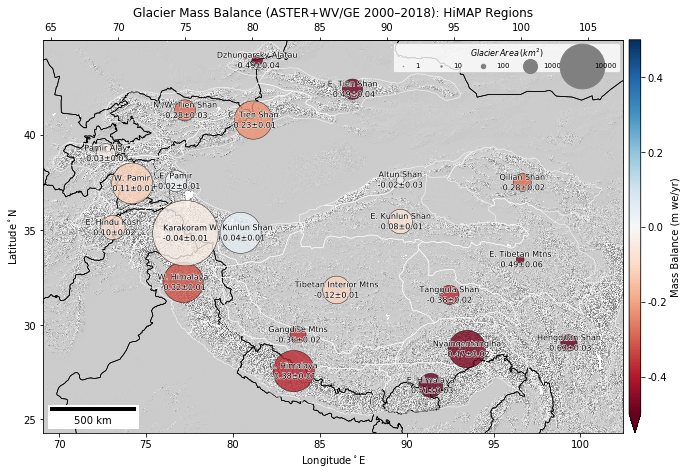

In [161]:
hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex_himap_region_%s' % mb_unit, clim=region_clim)

In [162]:
#Number of cells per region
glac_gdf_mb_hex_region_agg['mb_m3wea','sum','size']

himap_region
Pamir Alay               72.00
E. Hindu Kush           102.00
W. Pamir                156.00
E. Pamir                 49.00
W. Himalaya             213.00
N./W. Tien Shan         123.00
Karakoram               153.00
W. Kunlun Shan          129.00
C. Tien Shan            120.00
Dzhungarsky Alatau       26.00
C. Himalaya             173.00
Gangdise Mtns           141.00
Tibetan Interior Mtns   157.00
E. Tien Shan             68.00
Altun Shan               15.00
E. Kunlun Shan          131.00
E. Himalaya              95.00
Tanggula Shan            81.00
Nyainqentanglha         187.00
E. Tibetan Mtns          26.00
Qilian Shan              99.00
Hengduan Shan           106.00
Name: (mb_m3wea, sum, size), dtype: float64

## Kaab et al regions

In [163]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": Kääb et al. (2015) Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, kaab_region_df, kaab_region_col)

One-time spatial join by hex
(2415, 66)


[0.12325339 0.33720061 0.45362373 1.3        0.49552989 0.67024369
 0.7767792  0.30018635 0.31951023 0.87251129 0.14743439 0.44933005]
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


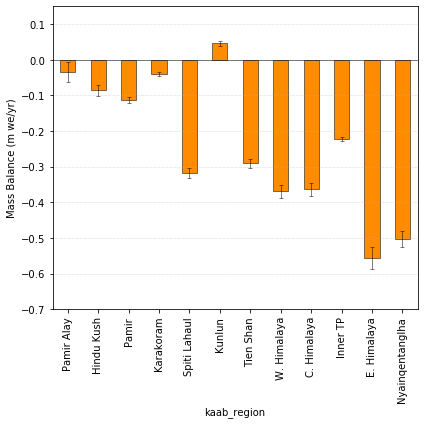

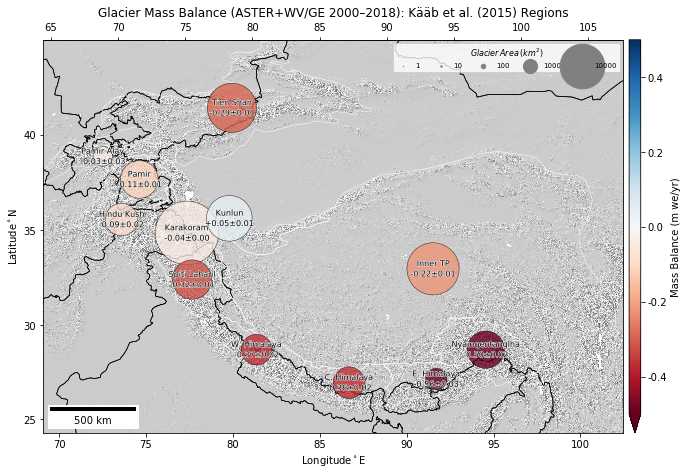

In [164]:
hex_agg_plot(glac_gdf_mb_hex_region_agg, kaab_region_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex_kaab_region_%s' % mb_unit, clim=region_clim)

## Combine with Brun estimates for Kaab regions

In [165]:
# Load Brun et al. (2017) numbers for Kaab et al (2015) regions
brun_fn = os.path.join(topdir, 'brun_update.csv')
brun_df = pd.read_csv(brun_fn)
brun_df.set_index('region', inplace=True)
brun_df

orig_mb_mwea  orig_mb_err_mwea  orig_mb_gta  \
region                                                          
East Himalaya            -0.42              0.33        -1.00   
Central Himalaya         -0.33              0.32        -1.60   
Hindu Kush               -0.12              0.14        -0.60   
Inner TP                 -0.14              0.14        -1.80   
Karakoram                -0.03              0.14        -0.50   
Kunlun                    0.14              0.14         1.40   
Nyainqentanglha          -0.62              0.35        -4.00   
Pamir Alay               -0.04              0.14        -0.10   
Pamir                    -0.08              0.14        -0.60   
Spiti Lahaul             -0.37              0.15        -2.90   
Tien Shan                -0.28              0.32        -3.00   
West Himalaya            -0.34              0.15        -1.60   

                  orig_mb_err_gta  new_mb_mwea  new_mb_err_mwea  new_mb_gta  \
region                                                                        
East Himalaya                0.80        -0.42             0.20       -1.00   
Central Himalaya             1.50        -0.33             0.20       -1.60   
Hindu Kush                   0.70        -0.12             0.07       -0.60   
Inner TP                     1.80        -0.14             0.07       -1.80   
Karakoram                    2.50        -0.03             0.07       -0.50   
Kunlun                       1.40         0.14             0.08        1.40   
Nyainqentanglha              2.20        -0.62             0.23       -4.00   
Pamir Alay                   0.30        -0.04             0.07       -0.10   
Pamir                        1.00        -0.08             0.07       -0.60   
Spiti Lahaul                 1.20        -0.37             0.09       -2.90   
Tien Shan                    3.50        -0.28             0.20       -3.00   
West Himalaya                0.70        -0.34             0.09       -1.60   

                  new_mb_err_gta  
region                            
East Himalaya               0.50  
Central Himalaya            1.00  
Hindu Kush                  0.40  
Inner TP                    0.90  
Karakoram                   1.20  
Kunlun                      0.80  
Nyainqentanglha             1.50  
Pamir Alay                  0.10  
Pamir                       0.50  
Spiti Lahaul                0.70  
Tien Shan                   2.20  
West Himalaya               0.40

In [166]:
brun_df.head()
brun_df_cp = brun_df.copy()
short_lbl(brun_df)
brun_df.head()

orig_mb_mwea  orig_mb_err_mwea  orig_mb_gta  orig_mb_err_gta  \
region                                                                      
E. Himalaya         -0.42              0.33        -1.00             0.80   
C. Himalaya         -0.33              0.32        -1.60             1.50   
Hindu Kush          -0.12              0.14        -0.60             0.70   
Inner TP            -0.14              0.14        -1.80             1.80   
Karakoram           -0.03              0.14        -0.50             2.50   

             new_mb_mwea  new_mb_err_mwea  new_mb_gta  new_mb_err_gta  \
region                                                                  
E. Himalaya        -0.42             0.20       -1.00            0.50   
C. Himalaya        -0.33             0.20       -1.60            1.00   
Hindu Kush         -0.12             0.07       -0.60            0.40   
Inner TP           -0.14             0.07       -1.80            0.90   
Karakoram          -0.03             0.07       -0.50            1.20   

                  region_orig  
region                         
E. Himalaya     East Himalaya  
C. Himalaya  Central Himalaya  
Hindu Kush         Hindu Kush  
Inner TP             Inner TP  
Karakoram           Karakoram

In [167]:
# Merge with Brun
glac_gdf_mb_hex_region_agg_brun = glac_gdf_mb_hex_region_agg.merge(brun_df, left_index=True, right_index=True)

In [168]:
glac_gdf_mb_hex_region_agg_brun.index.name = 'kaab_region'

[0.12325339 0.33720061 0.45362373 1.3        0.49552989 0.67024369
 0.7767792  0.30018635 0.31951023 0.87251129 0.14743439 0.44933005]


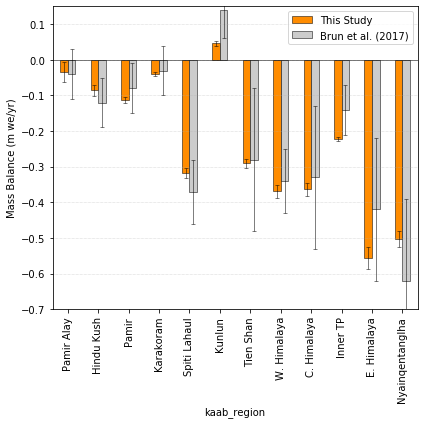

In [169]:
hex_agg_plot(glac_gdf_mb_hex_region_agg_brun, kaab_region_df, title, col=col,sigma_col=sigma_col, \
             out_fn_suffix='_hex_kaab_region_brun_%s' % mb_unit, clim=region_clim, map=False)

## Basin aggregation and excess meltwater

Need to aggregate original 25-km cells over union of all ENDO basins for proper RSS uncertainty

In [107]:
#Irrawady centroid is not actually in basin due to curvature
basin_df.at['Irrawady', 'centroid_x'] += 250000
basin_df.at['Irrawady', 'centroid_y'] -= 300000

In [130]:
basin_df.index = basin_df.index.str.replace('_',' ')
basin_df.rename({'Irrawady':'Irrawaddy'}, inplace=True)

In [131]:
basin_df

DN  ENDO  \
basin_name                                    
Irrawaddy                          51     0   
Salween                            68     0   
Ganges                             21     0   
Mekong                             29     0   
Tarim                            3546     1   
Amu Darya                        1270     1   
Indus                            5367     0   
Ili                              5073     1   
Syr Darya                        7195     1   
Yangtze                            11     0   
Inner Tibetan Plateau            8018     1   
Brahmaputra                        21     0   
Inner Tibetan Plateau Extended  26369     1   
Yellow                             27     0   

                                                                         geometry  \
basin_name                                                                          
Irrawaddy                       (POLYGON ((1224583.943096086 -732191.808398038...   
Salween                         (POLYGON ((672169.7126029407 -336521.677728236...   
Ganges                          (POLYGON ((-665049.6944216116 -495091.74933694...   
Mekong                          (POLYGON ((854358.4188662369 -207992.492380907...   
Tarim                           (POLYGON ((345884.0639544324 617350.1410054772...   
Amu Darya                       (POLYGON ((-2094846.421080804 1476189.78996319...   
Indus                           (POLYGON ((-1641980.304020386 -430007.62272057...   
Ili                             (POLYGON ((450350.5195374562 667594.5286882111...   
Syr Darya                       (POLYGON ((-1086009.053956824 477540.657353113...   
Yangtze                         (POLYGON ((771138.0908822966 11206.88876380805...   
Inner Tibetan Plateau           (POLYGON ((-468977.7175471765 -157170.40119378...   
Brahmaputra                     (POLYGON ((619033.9645721863 -509545.397443397...   
Inner Tibetan Plateau Extended  (POLYGON ((1383802.283126712 166858.519189611,...   
Yellow                          (POLYGON ((1875410.995698788 874285.9824641888...   

                                  centroid_x    centroid_y  
basin_name                                                  
Irrawaddy                       1,379,268.23 -1,655,012.38  
Salween                         1,210,804.92 -1,157,828.84  
Ganges                           -381,727.37 -1,042,360.00  
Mekong                          1,926,020.68 -1,752,219.17  
Tarim                            -185,054.84    375,149.41  
Amu Darya                      -1,719,095.50    559,547.89  
Indus                          -1,336,645.54   -360,903.37  
Ili                              -111,943.87  1,006,719.62  
Syr Darya                      -1,292,769.06  1,229,230.80  
Yangtze                         2,128,186.58   -371,513.39  
Inner Tibetan Plateau             127,911.28   -250,585.40  
Brahmaputra                       634,861.77   -903,185.57  
Inner Tibetan Plateau Extended  1,154,369.81    434,642.59  
Yellow                          1,913,850.34    298,669.11

In [132]:
basin_melt_gt_clim = (-5, 0)
mb_unit = 'Gta'
ylim = (-6, 0)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": WBM Basins"
out_fn_suffix = '_hex_basin_Gta'
col = ('meltwater_Gta', 'sum','sum')
sigma_col = ('meltwater_Gta_sigma','sum','rss')
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)

One-time spatial join by hex
(2422, 67)


[0.47091382 1.3        0.10703706 0.40538415 1.03543571 0.22886109
 0.30586995 0.49914371 0.138805   0.05392839 0.00148119 0.00307149
 0.00897571 0.06892669]
Plotting borders
Plotting scatterplot of ('meltwater_Gta', 'sum', 'sum') values
Adding annotations


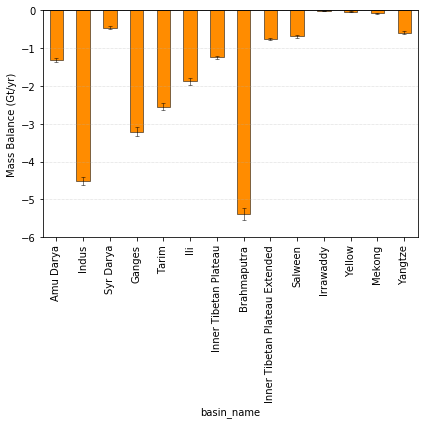

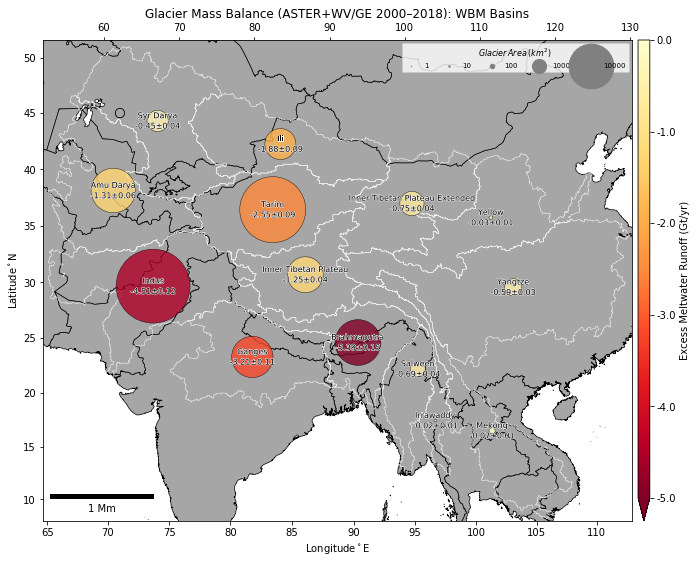

In [133]:
#hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, \
#             col=('meltwater_Gta', 'sum','sum'), sigma_col=('meltwater_Gta_sigma','sum','rss'), \
#             clim=basin_melt_gt_clim, hs_bg=False)
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, col=col, sigma_col=sigma_col, \
             out_fn_suffix='_hex_basin_%s' % mb_unit, clim=basin_melt_gt_clim, hs_bg=False)

## Excess meltwater analysis and SLR

In [134]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','sum']/1E9

basin_name
Amu Darya                        -1.02
Indus                            -3.46
Syr Darya                        -0.34
Ganges                           -3.14
Tarim                            -1.01
Ili                              -1.82
Inner Tibetan Plateau            -1.07
Brahmaputra                      -5.02
Inner Tibetan Plateau Extended   -0.70
Salween                          -0.68
Irrawaddy                        -0.02
Yellow                           -0.03
Mekong                           -0.07
Yangtze                          -0.57
Name: (mb_m3wea, sum, sum), dtype: float64

In [135]:
glac_gdf_mb_hex_basin_agg['mb_m3wea_sigma','sum','rss']/1E9

basin_name
Amu Darya                        0.09
Indus                            0.16
Syr Darya                        0.06
Ganges                           0.12
Tarim                            0.13
Ili                              0.10
Inner Tibetan Plateau            0.05
Brahmaputra                      0.18
Inner Tibetan Plateau Extended   0.04
Salween                          0.04
Irrawaddy                        0.01
Yellow                           0.01
Mekong                           0.01
Yangtze                          0.03
Name: (mb_m3wea_sigma, sum, rss), dtype: float64

In [136]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','size']

basin_name
Amu Darya                        224.00
Indus                            460.00
Syr Darya                        131.00
Ganges                           153.00
Tarim                            360.00
Ili                              127.00
Inner Tibetan Plateau            246.00
Brahmaputra                      338.00
Inner Tibetan Plateau Extended   157.00
Salween                           83.00
Irrawaddy                          8.00
Yellow                            12.00
Mekong                            19.00
Yangtze                          104.00
Name: (mb_m3wea, sum, size), dtype: float64

In [137]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a','sum']/1E9

basin_name
Amu Darya                        -1.31
Indus                            -4.51
Syr Darya                        -0.45
Ganges                           -3.21
Tarim                            -2.55
Ili                              -1.88
Inner Tibetan Plateau            -1.25
Brahmaputra                      -5.39
Inner Tibetan Plateau Extended   -0.75
Salween                          -0.69
Irrawaddy                        -0.02
Yellow                           -0.03
Mekong                           -0.07
Yangtze                          -0.59
Name: (meltwater, total_m3a, sum), dtype: float64

In [138]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a_sigma','rss']/1E9

basin_name
Amu Darya                        0.06
Indus                            0.12
Syr Darya                        0.04
Ganges                           0.11
Tarim                            0.09
Ili                              0.09
Inner Tibetan Plateau            0.04
Brahmaputra                      0.15
Inner Tibetan Plateau Extended   0.04
Salween                          0.04
Irrawaddy                        0.01
Yellow                           0.01
Mekong                           0.01
Yangtze                          0.03
Name: (meltwater, total_m3a_sigma, rss), dtype: float64

In [139]:
basin_sum = glac_gdf_mb_hex_basin_agg.sum()
basin_sum/1E9

mb_m3wea_sigma       sum              sum       10.53
                                      rss        1.03
                                      rms        0.08
mb_m3wea             sum              sum      -18.96
                                      size       0.00
z_med                median           mean       0.00
                                      median     0.00
Area_all             sum              sum        0.00
meltwater            total_m3a        sum      -22.71
                     total_m3a_sigma  sum        8.00
                                      rss        0.84
                                      rms        0.06
centroid_x                                       0.01
centroid_y                                      -0.00
mb_Gta               sum              sum       -0.00
mb_Gta_sigma         sum              rss        0.00
mb_mwea              sum              sum       -0.00
mb_mwea_sigma        sum              rss        0.00
meltwater_Gta        sum    

In [140]:
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta', 'sum','sum')], \
                                  basin_sum[('meltwater_Gta_sigma','sum','rss')]))

-22.71±0.84 Gt/yr


In [141]:
#Exohreic basins
endo_sum = glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()
endo_sum/1E9

mb_m3wea_sigma       sum              sum        5.85
                                      rss        0.56
                                      rms        0.04
mb_m3wea             sum              sum      -13.00
                                      size       0.00
z_med                median           mean       0.00
                                      median     0.00
Area_all             sum              sum        0.00
meltwater            total_m3a        sum      -14.51
                     total_m3a_sigma  sum        4.77
                                      rss        0.48
                                      rms        0.04
centroid_x                                       0.01
centroid_y                                      -0.01
mb_Gta               sum              sum       -0.00
mb_Gta_sigma         sum              rss        0.00
mb_mwea              sum              sum       -0.00
mb_mwea_sigma        sum              rss        0.00
meltwater_Gta        sum    

In [142]:
#Exo SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (endo_sum[('mb_Gta', 'sum','sum')], \
                                  endo_sum[('mb_Gta_sigma','sum','rss')]))

-13.00±0.56 Gt/yr


In [143]:
#Exo Meltwater SLR contribution
print('%0.2f\u00b1%0.2f Gt/yr' % (endo_sum[('meltwater_Gta', 'sum','sum')], \
                                  endo_sum[('meltwater_Gta_sigma','sum','rss')]))

-14.51±0.48 Gt/yr


In [144]:
print('%0.3f\u00b1%0.3f mm/yr' % (endo_sum['mb_Gta','sum','sum']/Gt2mm, endo_sum['mb_Gta_sigma','sum','rss']/Gt2mm))

-0.036±0.002 mm/yr


In [145]:
#Total for 2000-2018
18*endo_sum/1E9/Gt2mm

mb_m3wea_sigma       sum              sum       0.29
                                      rss       0.03
                                      rms       0.00
mb_m3wea             sum              sum      -0.65
                                      size      0.00
z_med                median           mean      0.00
                                      median    0.00
Area_all             sum              sum       0.00
meltwater            total_m3a        sum      -0.72
                     total_m3a_sigma  sum       0.24
                                      rss       0.02
                                      rms       0.00
centroid_x                                      0.00
centroid_y                                     -0.00
mb_Gta               sum              sum      -0.00
mb_Gta_sigma         sum              rss       0.00
mb_mwea              sum              sum      -0.00
mb_mwea_sigma        sum              rss       0.00
meltwater_Gta        sum              sum     

In [146]:
append_centroid_xy(basin_df_endo)
glac_gdf_mb_hex_basin_endo_agg = hex_agg(glac_gdf_mb_hex, basin_df_endo, 'ENDO')
glac_gdf_mb_hex_basin_endo_agg

One-time spatial join by hex
(2422, 66)


mb_m3wea_sigma                                       mb_m3wea           \
                  sum                                            sum            
                  sum            rss          rms                sum     size   
ENDO                                                                            
1    4,681,853,949.19 207,269,940.92 5,874,239.48  -5,960,889,760.31 1,245.00   
0    5,846,727,919.58 273,137,402.59 7,961,464.15 -13,001,924,168.23 1,177.00   

        z_med           Area_all          meltwater                   \
       median                sum          total_m3a  total_m3a_sigma   
         mean   median       sum                sum              sum   
ENDO                                                                   
1    4,822.84 4,934.62 48,080.97  -8,198,992,658.30 3,226,080,990.81   
0    5,288.52 5,330.41 49,216.04 -14,512,681,501.79 4,770,520,831.00   

                                  centroid_x  centroid_y mb_Gta mb_Gta_sigma  \
                                                            sum          sum   
                rss          rms                            sum          rss   
ENDO                                                                           
1    161,239,826.78 4,668,228.45 -462,571.98  617,780.25  -5.96         0.21   
0    228,663,444.87 6,708,009.64  875,027.54 -665,391.40 -13.00         0.27   

     mb_mwea mb_mwea_sigma meltwater_Gta meltwater_Gta_sigma  
         sum           sum           sum                 sum  
         sum           rss           sum                 rss  
ENDO                                                          
1      -0.12          0.00         -8.20                0.16  
0      -0.26          0.01        -14.51                0.23

In [147]:
glac_gdf_mb_hex_basin_agg

mb_m3wea_sigma                              \
                                            sum                               
                                            sum            rss          rms   
basin_name                                                                    
Amu Darya                        993,833,942.09  87,481,144.53 5,845,079.83   
Indus                          2,303,514,302.47 155,236,100.35 7,237,920.50   
Syr Darya                        466,923,469.61  59,837,339.09 5,228,012.59   
Ganges                         1,093,773,335.16 119,807,040.41 9,685,825.14   
Tarim                          1,699,341,954.51 132,255,575.28 6,970,480.85   
Ili                              798,757,496.46 101,353,795.44 8,993,695.01   
Inner Tibetan Plateau            428,681,298.95  49,055,984.16 3,127,695.31   
Brahmaputra                    1,973,361,555.42 182,141,599.61 9,907,196.94   
Inner Tibetan Plateau Extended   294,315,787.58  39,455,696.53 3,148,907.39   
Salween                          223,540,592.53  39,896,141.34 4,379,170.43   
Irrawaddy                         13,007,947.97   6,457,180.73 2,282,958.14   
Yellow                            11,602,380.49   6,266,066.72 1,808,857.65   
Mekong                            35,786,333.14  13,951,601.95 3,200,717.00   
Yangtze                          192,141,472.41  33,304,602.29 3,265,784.94   

                                        mb_m3wea           z_med           \
                                             sum          median            
                                             sum   size     mean   median   
basin_name                                                                  
Amu Darya                      -1,022,534,481.66 224.00 4,567.03 4,652.41   
Indus                          -3,461,953,854.79 460.00 5,212.05 5,263.62   
Syr Darya                        -339,453,323.81 131.00 3,882.41 3,862.84   
Ganges                         -3,142,931,613.34 153.00 5,430.58 5,414.27   
Tarim                          -1,005,181,978.13 360.00 5,005.66 5,133.89   
Ili                            -1,819,442,619.06 127.00 3,758.62 3,769.47   
Inner Tibetan Plateau          -1,069,694,019.67 246.00 5,748.97 5,826.21   
Brahmaputra                    -5,019,313,891.45 338.00 5,372.52 5,405.18   
Inner Tibetan Plateau Extended   -704,583,337.97 157.00 4,963.06 4,981.62   
Salween                          -684,839,528.55  83.00 5,318.45 5,351.21   
Irrawaddy                         -17,851,573.15   8.00 4,720.08 4,773.96   
Yellow                            -31,983,977.65  12.00 4,772.11 4,624.91   
Mekong                            -68,362,454.05  19.00 5,202.42 5,310.55   
Yangtze                          -574,687,275.24 104.00 5,239.90 5,235.66   

                                Area_all         meltwater                   \
                                     sum         total_m3a  total_m3a_sigma   
                                     sum               sum              sum   
basin_name                                                                    
Amu Darya                       9,900.64 -1,314,870,939.79   663,900,481.45   
Indus                          27,331.60 -4,514,044,031.38 1,647,959,866.19   
Syr Darya                       2,250.38   -454,666,392.51   327,131,544.77   
Ganges                          8,522.92 -3,208,773,607.01   992,296,595.02   
Tarim                          21,769.32 -2,549,607,737.45   933,600,595.59   
Ili                             4,811.65 -1,880,413,273.34   716,943,488.89   
Inner Tibetan Plateau           6,430.70 -1,245,523,883.90   329,953,642.31   
Brahmaputra                    10,494.15 -5,387,808,762.55 1,682,354,709.85   
Inner Tibetan Plateau Extended  2,918.28   -753,910,431.32   254,551,237.79   
Salween                         1,133.81   -689,473,438.88   215,349,054.84   
Irrawaddy                          31.14    -18,938,387.55    11,150,015.13   
Yellow                             64.

In [148]:
basin_summary = glac_gdf_mb_hex_basin_agg[[('mb_Gta','sum','sum'),('mb_Gta_sigma','sum','rss'),\
                          ('meltwater_Gta','sum','sum'),('meltwater_Gta_sigma','sum','rss')]]
basin_summary['ENDO'] = glac_gdf_mb_hex_basin_agg['ENDO']
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'_hex_basin_summary.pkl'
basin_summary.to_pickle(out_fn)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [149]:
basin_summary

mb_Gta mb_Gta_sigma meltwater_Gta  \
                                  sum          sum           sum   
                                  sum          rss           sum   
basin_name                                                         
Amu Darya                       -1.02         0.09         -1.31   
Indus                           -3.46         0.16         -4.51   
Syr Darya                       -0.34         0.06         -0.45   
Ganges                          -3.14         0.12         -3.21   
Tarim                           -1.01         0.13         -2.55   
Ili                             -1.82         0.10         -1.88   
Inner Tibetan Plateau           -1.07         0.05         -1.25   
Brahmaputra                     -5.02         0.18         -5.39   
Inner Tibetan Plateau Extended  -0.70         0.04         -0.75   
Salween                         -0.68         0.04         -0.69   
Irrawaddy                       -0.02         0.01         -0.02   
Yellow                          -0.03         0.01         -0.03   
Mekong                          -0.07         0.01         -0.07   
Yangtze                         -0.57         0.03         -0.59   

                               meltwater_Gta_sigma ENDO  
                                               sum       
                                               rss       
basin_name                                               
Amu Darya                                     0.06    1  
Indus                                         0.12    0  
Syr Darya                                     0.04    1  
Ganges                                        0.11    0  
Tarim                                         0.09    1  
Ili                                           0.09    1  
Inner Tibetan Plateau                         0.04    1  
Brahmaputra                                   0.15    0  
Inner Tibetan Plateau Extended                0.04    1  
Salween                                       0.04    0  
Irrawaddy                                     0.01    0  
Yellow                                        0.01    0  
Mekong                                        0.01    0  
Yangtze                                       0.03    0

One-time spatial join by hex
(2422, 67)
[0.47091382 1.3        0.10703706 0.40538415 1.03543571 0.22886109
 0.30586995 0.49914371 0.138805   0.05392839 0.00148119 0.00307149
 0.00897571 0.06892669]
Plotting borders
Plotting scatterplot of ('meltwater_Gta', 'sum', 'sum') values
Adding annotations


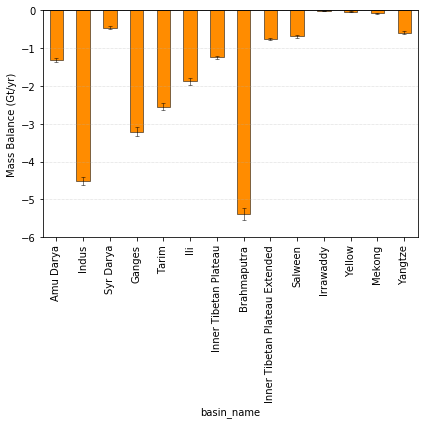

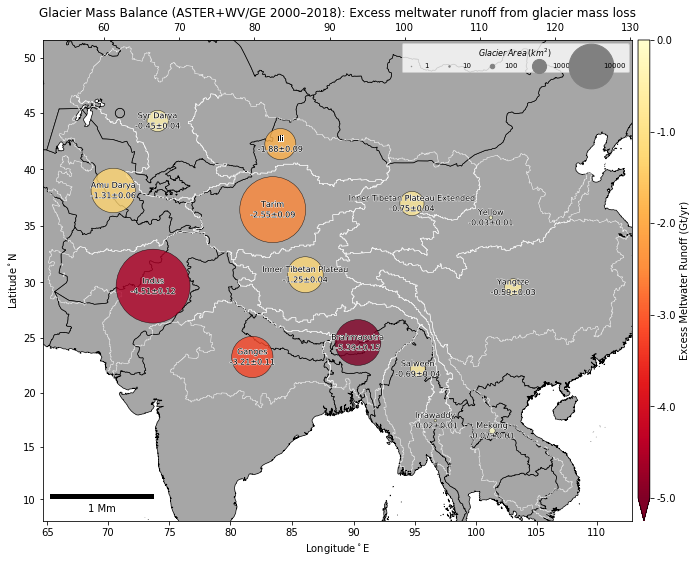

In [150]:
basin_melt_gt_clim = (-5, 0)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": Excess meltwater runoff from glacier mass loss"
out_fn_suffix = '_hex_basin_excess_Gta'
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_gt_clim, col=('meltwater_Gta','sum','sum'), sigma_col=('meltwater_Gta_sigma','sum','rss'), hs_bg=False)

In [151]:
glac_gdf_mb_hex_basin_agg

mb_m3wea_sigma                              \
                                            sum                               
                                            sum            rss          rms   
basin_name                                                                    
Amu Darya                        993,833,942.09  87,481,144.53 5,845,079.83   
Indus                          2,303,514,302.47 155,236,100.35 7,237,920.50   
Syr Darya                        466,923,469.61  59,837,339.09 5,228,012.59   
Ganges                         1,093,773,335.16 119,807,040.41 9,685,825.14   
Tarim                          1,699,341,954.51 132,255,575.28 6,970,480.85   
Ili                              798,757,496.46 101,353,795.44 8,993,695.01   
Inner Tibetan Plateau            428,681,298.95  49,055,984.16 3,127,695.31   
Brahmaputra                    1,973,361,555.42 182,141,599.61 9,907,196.94   
Inner Tibetan Plateau Extended   294,315,787.58  39,455,696.53 3,148,907.39   
Salween                          223,540,592.53  39,896,141.34 4,379,170.43   
Irrawaddy                         13,007,947.97   6,457,180.73 2,282,958.14   
Yellow                            11,602,380.49   6,266,066.72 1,808,857.65   
Mekong                            35,786,333.14  13,951,601.95 3,200,717.00   
Yangtze                          192,141,472.41  33,304,602.29 3,265,784.94   

                                        mb_m3wea           z_med           \
                                             sum          median            
                                             sum   size     mean   median   
basin_name                                                                  
Amu Darya                      -1,022,534,481.66 224.00 4,567.03 4,652.41   
Indus                          -3,461,953,854.79 460.00 5,212.05 5,263.62   
Syr Darya                        -339,453,323.81 131.00 3,882.41 3,862.84   
Ganges                         -3,142,931,613.34 153.00 5,430.58 5,414.27   
Tarim                          -1,005,181,978.13 360.00 5,005.66 5,133.89   
Ili                            -1,819,442,619.06 127.00 3,758.62 3,769.47   
Inner Tibetan Plateau          -1,069,694,019.67 246.00 5,748.97 5,826.21   
Brahmaputra                    -5,019,313,891.45 338.00 5,372.52 5,405.18   
Inner Tibetan Plateau Extended   -704,583,337.97 157.00 4,963.06 4,981.62   
Salween                          -684,839,528.55  83.00 5,318.45 5,351.21   
Irrawaddy                         -17,851,573.15   8.00 4,720.08 4,773.96   
Yellow                            -31,983,977.65  12.00 4,772.11 4,624.91   
Mekong                            -68,362,454.05  19.00 5,202.42 5,310.55   
Yangtze                          -574,687,275.24 104.00 5,239.90 5,235.66   

                                Area_all         meltwater                   \
                                     sum         total_m3a  total_m3a_sigma   
                                     sum               sum              sum   
basin_name                                                                    
Amu Darya                       9,900.64 -1,314,870,939.79   663,900,481.45   
Indus                          27,331.60 -4,514,044,031.38 1,647,959,866.19   
Syr Darya                       2,250.38   -454,666,392.51   327,131,544.77   
Ganges                          8,522.92 -3,208,773,607.01   992,296,595.02   
Tarim                          21,769.32 -2,549,607,737.45   933,600,595.59   
Ili                             4,811.65 -1,880,413,273.34   716,943,488.89   
Inner Tibetan Plateau           6,430.70 -1,245,523,883.90   329,953,642.31   
Brahmaputra                    10,494.15 -5,387,808,762.55 1,682,354,709.85   
Inner Tibetan Plateau Extended  2,918.28   -753,910,431.32   254,551,237.79   
Salween                         1,133.81   -689,473,438.88   215,349,054.84   
Irrawaddy                          31.14    -18,938,387.55    11,150,015.13   
Yellow                             64.